## <font color=darkslateblue>Test: Fitting Sérsic Profiles to DES redMaGiC Elliptical Galaxies
    
### <font color=darkslateblue>Aidan Cloonan
    
### <font color=darkslateblue>June 2021

There is a population of DES elliptical galaxies, called the redMaGiC catalog. The parent sample is some 10,000 from that catalog. We can use the Sérsic profile to find some structural properties of these galaxies, which will then allow for examination of selection effects. Before doing so, though, it's worthwhile to test on a small handful to make sure it works. In this notebook, I fit Sérsic profiles to images of a few DES galaxies from the redMaGiC catalog by minimizing a $\chi^2$ function.
    
The redMaGiC catalog can be found [here](https://des.ncsa.illinois.edu/releases/y1a1/key-catalogs/key-redmagic).
    
This is still a work-in-progress, and it needs to be cleaned up as well. I hope to update this fairly frequently.
    
**9/13 Update**:
* Rewritten uncertainty calculation function. This produces better fits than previously reported, but the images are slightly overfitted (for most, $\chi^2 \sim 0.8$).
    
Next, I'll implement a possible artificial uncertainty correction. Then, I'll also start to think about mapping the 7D parameter space for the Sérsic models, which will involve the use of a Monte-Carlo Markov Chain (MCMC).
    
I'll also try to work on better organizing this notebook.

In [1]:
# math, array manipulation, etc.
import numpy as np
#import esutil                    # must use desc-stack kernel
from timeit import default_timer

# astropy and affiliated packages
import astropy.io.fits as fits                     # writing to and opening FITS files
from astropy.cosmology import FlatLambdaCDM        # making cosmological calculations
from astropy import units as u                     # units
from astropy.table import Table                    # Table data structure
from photutils import background

from astroquery.vizier import Vizier

# for timing loops 
from tqdm import *
import time

# plots
import matplotlib.pyplot as plt
%matplotlib inline

# opening and extracting data from HDF5 files
import os
import h5py

# dask data structures, pandas operations, etc.
import dask as da
import dask.dataframe as dd

In [2]:
# the following commands make plots look better
def plot_prettier(dpi=200, fontsize=10): 
    plt.rcParams['figure.dpi']= dpi
    plt.rc("savefig", dpi=dpi)
    plt.rc('font', size=fontsize)
    plt.rc('xtick', direction='in') 
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=5) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=5) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [2., 2.])
    # if you don't have LaTeX installed on your laptop and this statement 
    # generates error, comment it out
    plt.rc('text', usetex=True)
    
plot_prettier()

In [3]:
def read_fits_table(filename):
    '''
    reads and returns data in a table from a FITS file
    '''
    hdu = fits.open(filename)
    data = Table(hdu[1].data)   # second index of the hdu corresponds to the data in my astropy table files
    hdu.close()
    
    return data

def read_fits_image(filename):
    '''
    reads and returns an image from a FITS file
    '''
    hdu = fits.open(filename)
    data = hdu[0].data
    header = hdu[0].header 
    hdu.close()
    
    return data

In [4]:
# get the table from the catalog
redmagic = read_fits_table('y3a2_gold2.2.1_redmagic_highdens.fits')

In [6]:
# here is how to get 10000 random galaxies from the catalog
nrmgal = len(redmagic)
rind = np.random.choice(nrmgal, size=10000, replace=False)

In [11]:
rm100_coord = redmagic[rind][:100]#['ra', 'dec']
rm100_coord
#for gal in rm100_coord:
#    print(gal['RA'], gal['DEC'])

coadd_object_id,ra,dec,zredmagic,zredmagic_e,mag_z,lum_z,zredmagic_samp_0,zredmagic_samp_1,zredmagic_samp_2,zredmagic_samp_3,weight,bin_number
int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float64,int16
344355985,47.2613202163856,-36.3996241286196,0.55477,0.015864575,19.952171,0.96565616,0.50235975,0.53905976,0.54285973,0.57085973,0.9326819181442261,3
471443469,68.0977602915823,-27.8480205298491,0.38010448,0.02467236,19.068148,0.9539749,0.40324575,0.37284574,0.38844576,0.41784576,1.161268949508667,2
483417942,61.7102185290091,-52.6487067703357,0.26431665,0.015073155,18.571323,0.6604777,0.25275713,0.23675714,0.27895716,0.25675714,1.0132131576538086,1
384419006,58.2906839287215,-18.2529851618384,0.41112435,0.029055232,19.64523,0.6624912,0.3998829,0.4041829,0.41718292,0.4396829,0.973606288433075,2
255919451,27.9411174049488,3.7239471936619,0.51431674,0.01753001,20.33571,0.5669405,0.5278378,0.5110378,0.53163785,0.52183783,0.9263206124305725,3
165479925,303.191230609591,-51.8695888188832,0.4683164,0.01476864,19.73246,0.8125417,0.4883137,0.4603137,0.4714137,0.44621372,1.0918244123458862,2
219540321,21.0039708090122,-52.3299936923914,0.6047009,0.01835367,20.474806,0.7198775,0.6282714,0.6121714,0.6048714,0.6166714,1.0602302551269531,3
227101962,21.6509646922853,-63.591463952082,0.3529435,0.014552586,18.043985,2.0749233,0.35490024,0.36450025,0.33550024,0.37400025,0.8575582504272461,2
88425342,338.218059774647,-42.0457871933621,0.48571834,0.015854746,20.24424,0.54671764,0.489901,0.470701,0.504801,0.49160102,1.1086053848266602,2


In [12]:
vsearch = Vizier

# extract table from the Jacobs, et al. (2019) catalog

vsearch.ROW_LIMIT = -1 # select all rows, not just default 50 first rows
vsearch.columns=['Cand', 'objID', 'RAJ2000', 'DEJ2000', 'Grade', 'z', 'imag'] # select default columns and objid column

sl_jacobs_catalog = vsearch.get_catalogs('J/ApJS/243/17/table1')
sl_table = sl_jacobs_catalog[0]

In [16]:
sl_table

Cand,objID,RAJ2000,DEJ2000,Grade,z,imag
,,deg,deg,,,mag
bytes14,int32,float64,float64,float32,float32,float32
DESJ0002-3507,139741252,0.59845,-35.12122,2.3,0.51,19.2
DESJ0003-3348,139823797,0.81825,-33.80120,2.7,0.68,19.3
DESJ0006-4429,142775105,1.68592,-44.49735,2.0,0.53,18.6
DESJ0007-4434,142779522,1.87201,-44.57949,3.0,0.52,18.1
DESJ0010-4315,182452355,2.62678,-43.25413,2.3,0.84,19.9
DESJ0011-4614,182003535,2.97135,-46.23942,3.0,0.60,18.5
DESJ0013+0040,179698697,3.29016,0.66767,2.3,0.75,20.0
DESJ0013-0335,180799530,3.29224,-3.59597,2.3,0.53,19.1


In [10]:
for row in sl_table['RAJ2000', 'DEJ2000', 'Cand'][:30]:
    print(row[0], row[1], row[2])

0.59845 -35.12122 DESJ0002-3507
0.81825 -33.8012 DESJ0003-3348
1.68592 -44.49735 DESJ0006-4429
1.87201 -44.57949 DESJ0007-4434
2.62678 -43.25413 DESJ0010-4315
2.97135 -46.23942 DESJ0011-4614
3.29016 0.66767 DESJ0013+0040
3.29224 -3.59597 DESJ0013-0335
3.38649 -42.65808 DESJ0013-4239
3.60116 0.69596 DESJ0014+0041
3.96725 -2.51252 DESJ0015-0230
3.92831 -46.60305 DESJ0015-4636
4.32556 1.97183 DESJ0017+0158
4.50945 -45.82622 DESJ0018-4549
4.81803 -41.61405 DESJ0019-4136
5.39182 -40.66717 DESJ0021-4040
6.23732 -34.01479 DESJ0024-3400
6.29223 -31.65755 DESJ0025-3139
6.52789 -55.07581 DESJ0026-5504
6.75025 -4.22321 DESJ0027-0413
7.19578 -51.14695 DESJ0028-5108
7.832 -64.3438 DESJ0031-6420
8.5267 -24.09052 DESJ0034-2405
8.78153 -25.44932 DESJ0035-2526
9.3628 -41.53054 DESJ0037-4131
9.69256 -29.60189 DESJ0038-2936
10.16456 -37.54704 DESJ0040-3732
10.28753 -0.73025 DESJ0041-0043
10.73881 -37.31623 DESJ0042-3718
11.74831 1.46004 DESJ0046+0127


In [13]:
jacobs_path = '/Users/aidan/Desktop/sl_project/des-sl-selection/test_jacobs_objects/'

def jacobs_img_collage(objs, nrow, ncol
                     , figsize=(10,2), npix=200, path=jacobs_path, scale=0.2, savefig=None
                     , title_bool = False, title = None):
    """
    plot image collage of nrow x ncol rows and columns
    
    Parameters:
    -----------
    objs: 64 bit integers, SDSS object IDs of galaxies to display
    ras, decs: float, right ascensions and declinations (in degrees) of the galaxies to display
    
    The fetched image file is stored in the subdirectory specified by path using object ID as a file name. 
    """
    fig, axs = plt.subplots(nrow, ncol, figsize=figsize)
    # Check that PIL is installed for jpg support
    if 'jpg' not in fig.canvas.get_supported_filetypes():
        raise ValueError("PIL required to load SDSS jpeg images")

    for obj, ax in zip(objs, axs.flatten()):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        
        datafile = os.path.join(path, obj)
        image = read_fits_image(datafile)

        ax.imshow(image, origin='lower', cmap='cubehelix')
        ax.set_aspect('auto')

    #plt.tight_layout()
    fig.subplots_adjust(hspace=0, wspace=0)
    if savefig != None:
        plt.savefig(savefig,bbox_inches='tight')
    if title_bool == True:
        fig.suptitle(title)
    plt.show()

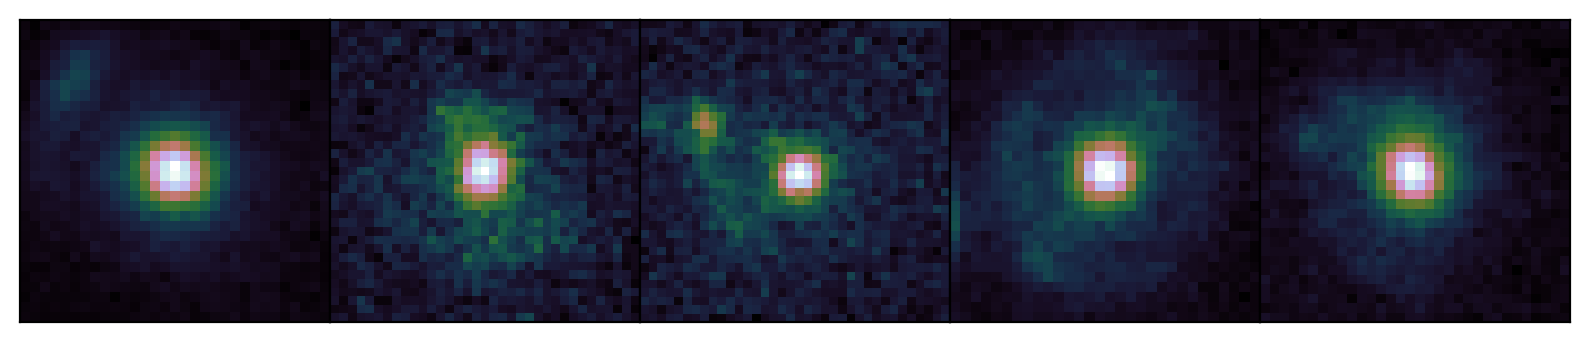

In [14]:
def get_files(path):
    files = np.array(os.listdir(path))
    finds = [i for i, f in enumerate(files) if '.fits' in f]
    files = files[finds]
    return files

jacobs_objs = get_files(jacobs_path)

jacobs_img_collage(jacobs_objs, 1, 5)

#### <font color=darkslateblue>Test on 16 redMaGiC Strong Lenses
    
I have a small dataset of 16 strong lenses from redMaGiC. Before we model for 10000 strong lenses, let's test a Sérsic profile fitting method on this smaller dataset.
    
A desirable result would be consistently seeing rescaled residuals between the fitted profile and the DES images in the range $[-5, 5]$. The rescaled residuals are defined as:
    
$$
r = \frac{y_{\rm data} - y_{\rm fit}}{\sigma_{\rm tot}},
$$
    
where $y_{\rm data}$ are pixel values from the raw DES image, $y_{\rm fit}$ are pixel values from the fitted Sérsic profile, and $\sigma_{\rm tot}$ is the total uncertainty. To find $\sigma_{\rm tot}$, we have to account for both background flux and galactic flux, which means we define $\sigma_{\rm tot}$ as:
    
$$
\sigma_{\rm tot} = \sqrt{\sigma_{\rm bg}^2 + \sigma_{\rm gal}^2}.
$$
    
For $\sigma_{\rm bg}$, for most images, we can use the standard deviation of the lower 90% of pixels, as this lower 90% will usually constitute the background in essense. More generally, though, it's probably more effective to use some astropy stuff at [this link](https://photutils.readthedocs.io/en/stable/background.html).
    
We can assume that the pixel values in the image's galaxy follow a Poisson distribution, which means that $\sigma_{\rm gal}^2 = \mu_{\rm gal}$. Here, those pixels are taken to be those which correspond to the upper 10% of values.

In [15]:
from astropy.modeling import functional_models

from scipy.optimize import differential_evolution
from timeit import default_timer

In [16]:
def my_sigma_clip_2d(x, niter = 3, s_th = 3., p=True):
    
    # make sure we can use filtering
    xnp = np.array(x)
    
    # array that will be used to mark non-outliers
    noutflag = np.ones(np.shape(x), dtype = bool)
    
    while niter > 0:
        
        newxnp = xnp[noutflag]
        
        xm   = np.mean(newxnp)                            # mean
        xvar = (((newxnp-xm)**2)/(newxnp.size-1)).sum()             # variance
        #if newxnp.size<100: print(newxnp.size-1)
        #xvar = np.var(newxnp, ddof=1)
        xstd = np.sqrt(xvar)                              # standard deviation
        #print(xstd)
        
        noutflag = (np.abs(xnp - xm) / xstd) < s_th       # array where non-outliers -> True
        niter -= 1                                        #                 outliers -> False
        
    return xm, xvar, xstd, newxnp.size-1

In [17]:
# model?
# use chi-squared test on 2D arrays
# function accepts a vector with the Sersic2D parameters, with the img array as an arg

def chi2_sersic(v, *args):
    
    a, r, n, x0, y0, e, th = v
    npar = len(v)
    
    # args is the grid of I_gal values and grid of uncertainties
    #print(args[0][0])
    img_gal = args[0]; stds = args[1]
    nrow, ncol = img_gal.shape
    xgrid, ygrid = np.meshgrid(np.arange(ncol), np.arange(nrow))
    
    # initialize Sersic profile
    model = functional_models.Sersic2D(amplitude=a, r_eff=r, n=n
                                         , x_0=x0, y_0=y0
                                         , ellip=e, theta=th)
    profile = model(xgrid, ygrid)
    
    pchi2 = ((img_gal - profile) / stds)**2
    
    # E^2, sum of squared errors
    e2 = np.sum(pchi2)
    norm = pchi2.size - npar
    
    # reduced chi2
    redchi2 = e2 / norm
    
    #test_stat = np.abs(redchi2 - 1)
    
    return redchi2

In [18]:
def plot_gaussian(xmin, xmax, mu = 0, s2 = 1., nplot = 1000): 
        xe = np.linspace(xmin, xmax, nplot) # use numpy functions to generate a vector of evenly spaced x values
        ge = np.exp(-0.5 * (xe - mu)**2 / s2) / np.sqrt(2. * np.pi * s2) # and compute Gaussian pdf for them
        plt.plot(xe, ge, label='Gaussian pdf', color='purple', lw=2.)
        plt.legend(loc='upper left', fontsize = 12) # place legend with labels that were defined

from scipy.special import gamma        

def plot_hist_and_gaussian(x, bins = 'auto', figsize = (6,6), density = True, 
                           yscale='linear', xlabel = 'x', 
                           gaussian = False, mu = 0., s2 = 1.):

    plt.figure(figsize = figsize) # define figure and its dimensions
    plt.xlabel(xlabel, fontsize=12) # x-axis label
    plt.yscale(yscale)
    if density: plt.ylabel('density of samples') # y-axis label
    else:       plt.ylabel('histogram') 
        
    plt.hist(x, density = density, color = 'slateblue', bins = bins) # produce histogram of xs values

    #plt.xlim(0,3000)
    if gaussian: 
        plot_gaussian(min(x), max(x), mu = mu, s2 = s2)

In [19]:
import os
from scipy.optimize import minimize

from astropy.stats import SigmaClip
from photutils.background import StdBackgroundRMS

# get files

def get_files(path):
    files = np.array(os.listdir(path))
    finds = [i for i, f in enumerate(files) if '.fits' in f]
    files = files[finds]
    return files

# subtract background mean, divide by uncertainty
# set negative values to 0
# return rescaled image and uncertainties

'''
def rescale_img(img):
    
    perc90 = np.percentile(img, 90)
        
    inds = (img < perc90)
    img_bg = img[inds]
    
    bg_mean = np.mean(img_bg)
    bg_var = np.var(img_bg)
    
    inds = (img >= perc90)
    img_gal = img[inds]
    
    gal_mean = np.mean(img_gal) # assume Poisson distribution
    
    # subtract bg_mean
    img = img - bg_mean
    
    # set negative values to 0
    inds = img < 0
    img[inds] = 0
    
    return img, (np.sqrt(bg_var), np.sqrt(gal_mean))
    '''

def rms(arr):
    '''
    calculates the root mean square of an array
    '''
    sq_mean = np.mean(arr**2)
    return np.sqrt(sq_mean)

# rename and redo function

def get_img_uncertainties(img, num=1.0):
    '''
    a function that estimates uncertainties in the pixel values of redmagic 
    images, both from background and from the elliptical galaxy
    
    also returns the grid of I_gal values, which is what the Sérsic model is fit to
    
    inputs:
    --------
    
    img        ---    2D array; a DES redMaGiC image with an elliptical galaxy that a Sérsic
                      model is being fit to  
    
    outputs:
    --------
    
    img_gal    ---    2D array; alternatively img_gal_copy (explained below); the grid of I_gal values
                      calculated from estimation of a constant I_bg
    
    std_arr    ---    2D array; grid of uncertainties in corresponding pixel values from the DES image
                      
    
    PSEUDOCODE:
    
    get background and galaxy pixels as before
    
    I_bg = np.mean(bg_pixels)
    
    sigma_bg = root mean square of bg_pixels
    
    I_gal = I_tot - I_bg
    
    sigma_gal = np.sqrt(I_gal)
    
    invalid_sgal_ind = where sigma_gal is inf or nan
    
    sigma_gal[invalid_sgal_ind] = 0
    
    sigma_tot = np.sqrt(sigma_bg**2 + sigma_gal**2)
    
    return I_gal, sigma_tot
    
    '''

    # the 93rd percentile is an arbitrary threshold used to conveniently
    # avoid negative I_bg in the uncertainty calculation
    #perc93 = np.percentile(img, 96)
        
    # getting background pixels
    #inds = (img < perc93)
    #bg_pixels = img[inds]
    
    sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
    
    bg_pixels = sigma_clip(img, masked=False, axis=None)
    
    ## I_bg and std_bg
    
    img_bg = np.mean(bg_pixels)  # I_bg
    
    #std_bg = rms(img_bg)
    
    bkgrms = StdBackgroundRMS(sigma_clip)
    
    std_bg = bkgrms(img)   # \sigma_bg
    #print(std_bg)
    
    ## I_gal
    
    img_gal = img - img_bg          # I_tot = I_gal + I_bg
    
    #std_gal = np.sqrt(img_gal)
    std_gal = np.sqrt(num * img_gal) 
    
    # set negative I_gal values to 0
    invalid_sgal_ind = (std_gal == np.inf) | (std_gal == -np.inf)
    #print(np.count_nonzero(invalid_sgal_ind))
    std_gal[invalid_sgal_ind] = 0
    
    std_gal = np.nan_to_num(std_gal)
    
    ## estimate uncertainties

    std_arr = np.sqrt(std_gal**2 + std_bg**2)
    
    # returning img_gal retains the negative I_gal pixel values when fitting
    # returning img_gal_copy gets rid of negative I_gal pixel values when fitting
    return img_gal, std_arr


'''
def get_img_uncertainties(img):
    
    readout = 7
    
    img_abs = np.abs(img)
    
    #std_arr = np.sqrt(img_abs + readout**2)
    std_arr = np.sqrt(img_abs)
    #print(std_arr)
    
    perc90 = np.percentile(img, 93)
        
    inds = (img < perc90)
    img_bg = img[inds]
    
    bg_mean = np.mean(img_bg)
    bg_var = np.var(img_bg)
    
    inds = (img >= perc90)
    img_gal = img[inds]
    
    gal_mean = np.mean(img_gal) # assume Poisson distribution
    
    # subtract bg_mean
    img = img - bg_mean
    
    #std_arr = np.sqrt(img_abs + 7**2)
    
    #std_arr = np.sqrt(img)
    
    # set negative values to 0
    inds = img < 0
    img[inds] = 0
    
    #std_arr = np.sqrt(img)
    
    return img, std_arr'''
    

# run on set of files, w/ a function

def chi2_on_fileset(path, parameters, num=1.0, dtypes=None, npop=50):
    '''
    path       - str; path on the local system to the set of FITS image files
    parameters - list of strs; except for DES ID, each index should refer to a
                 parameter that is being fitted in the model function 
    dtypes     - list of datatypes; corresponds to the datatypes of each parameter
                 
    '''
    
    # make an astropy table with each index of parameters as a column
    chi2_table = Table(names=parameters, dtype=['str'] + ['float64'] * 7)
    
    files = get_files(path)
    
    std_lst = []
    
    for file in files:
        
        strngs = file.split('_')
        desid = strngs[0]
        
        # lead to file and open it
        datafile = os.path.join(path, file)
        image = read_fits_image(datafile)
        
        # get grid of I_gal values and pixel uncertainties
        img_gal, stds = get_img_uncertainties(image, num)
        
        # define args, bounds
        args = [img_gal, stds]
        
        nrow, ncol = image.shape

        amin, amax, rmin, rmax, nmin, nmax = 1e-3, 500, 1e-3, 15, 1e-3, 20;
        x0min, x0max, y0min, y0max = ncol/2 - 3, ncol/2 + 3, nrow/2 - 3, nrow/2 + 3
        emin, emax, thmin, thmax = 0, 1, 0, 2*np.pi
        bounds = np.array([(amin, amax), (rmin, rmax), (nmin, nmax)
                           , (x0min, x0max), (y0min, y0max)
                           , (emin, emax), (thmin, thmax)])
        
        npop = 30
        
        a0 = amin + (amax - amin) * np.random.uniform(0,1, size=npop)
        r0 = rmin + (rmax - rmin) * np.random.uniform(0,1, size=npop)
        n0 = nmin + (nmax - nmin) * np.random.uniform(0,1, size=npop)
        x0 = (ncol / 2) * np.random.uniform(0.8, 1.2, size=npop)
        y0 = (nrow / 2) * np.random.uniform(0.8, 1.2, size=npop)
        e0 = emin + (emax - emin) * np.random.uniform(0,1, size=npop)
        th0 = thmin + (thmax - thmin) * np.random.uniform(0,1, size=npop)
        
        v0 = np.column_stack((a0, r0, n0, x0, y0, e0, th0))
        
        tstart = default_timer()
        
        
        run = differential_evolution(chi2_sersic, popsize=npop, tol = 1e-4
                                     , bounds=bounds, args=args
                                     , init = v0
                                    )
        '''run = minimize(chi2_sersic, x0 = v0[0], args=args, bounds=bounds
                       , tol=1e-2, method='CG')'''
        

        print("{} completed in {:>.5g} sec".format(desid, default_timer() - tstart))
        print("minimum at:",run.x)
        print('f =', run.fun)
        
        #print('proportion of negative I_gal values: ', np.size(img_gal[img_gal < 0]) / np.size(img_gal))
        
        trow = [desid] + list(run.x)
        
        chi2_table.add_row(vals=trow)
        
        std_lst.append(stds)
        
        #break
        
    print('Done.')
    
    return chi2_table, std_lst
    
    # for each file in path, add a column to the table
    #                      , run the file through the model function
    #                      , put the output parameters into that new column in the table

In [22]:
path = '/Users/aidan/Desktop/sl_project/des-sl-selection/test_redmagic_rband/'
parameters = ['DES_ID', 'amplitude', 'r_eff', 'n'
              , 'x_0', 'y_0'
              , 'ellip', 'theta']

# run on 16 files
bestfit_table, std_lst = chi2_on_fileset(path=path, parameters=parameters, num=1.0)

/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt
/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/astropy/modeling/functional_models.py:2500: RuntimeWarning: overflow encountered in power
  return amplitude * np.exp(-bn * (z ** (1 / n) - 1))


DES0439-5331 completed in 1.4598 sec
minimum at: [64.52028993  3.73644629  0.72917919 20.39591241 19.6763225   0.38798122
  4.37335123]
f = 0.7908548854317072


/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt


DES0327-4831 completed in 1.6437 sec
minimum at: [83.36737137  4.3150481   1.00299752 22.51485804 22.74448639  0.16694015
  4.22532771]
f = 0.642212030835495


/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt


DES0558-5540 completed in 2.4453 sec
minimum at: [5.84580530e+01 3.47357661e+00 8.66926328e-01 1.92736261e+01
 1.93126835e+01 1.87301647e-02 4.77621653e+00]
f = 0.6837046374914736


/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt


DES0048-4540 completed in 1.9758 sec
minimum at: [75.57857276  4.04665911  0.83402832 24.01827277 24.31193333  0.21203744
  0.49144262]
f = 0.753346442633157


/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt
/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/astropy/modeling/functional_models.py:2500: RuntimeWarning: overflow encountered in power
  return amplitude * np.exp(-bn * (z ** (1 / n) - 1))


DES0343-4331 completed in 1.788 sec
minimum at: [73.88851438  4.33683682  0.60762364 24.93843534 25.36281627  0.19744882
  4.10947793]
f = 0.7865428608800729


/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt


DES0431-4249 completed in 1.877 sec
minimum at: [37.93772419  3.26339574  0.87624173 25.1172727  25.12709573  0.03975761
  3.71940356]
f = 0.7555999728918177


/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt


DES0031-5831 completed in 1.9487 sec
minimum at: [89.37145294  3.8530428   0.71825983 17.73364595 17.57637218  0.38644785
  2.5685639 ]
f = 0.7432809368602676


/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt


DES2318-5540 completed in 1.6705 sec
minimum at: [94.97980989  3.315341    0.91360239 19.4276497  18.95520193  0.10595663
  3.04190048]
f = 0.6724155984353477


/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt


DES0432-4706 completed in 2.136 sec
minimum at: [31.46943062  3.75436396  0.74712676 22.74219552 23.38608288  0.12616685
  4.43521035]
f = 0.7486705851976883


/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt


DES2258-5831 completed in 1.8337 sec
minimum at: [2.38381995e+02 5.14508429e+00 7.79476790e-01 1.83100683e+01
 1.75980145e+01 1.59489300e-01 1.41072878e+00]
f = 0.3832159405210635


/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt


DES0421-4457 completed in 1.882 sec
minimum at: [56.1725454   3.20191171  0.72270892 23.98396531 24.43062702  0.14491076
  1.67631813]
f = 0.7790470070290736


/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt


DES2111-5040 completed in 1.7229 sec
minimum at: [4.44538384e+01 3.91048492e+00 6.58951359e-01 2.15326302e+01
 2.20764457e+01 2.73737431e-02 1.93927957e+00]
f = 0.7255335563536415


/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt


DES0137-4748 completed in 1.9166 sec
minimum at: [76.64356398  5.08485949  1.02027906 22.71936799 22.83928886  0.19896397
  4.85502862]
f = 0.6140066285977922


/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt


DES0049-4914 completed in 1.9432 sec
minimum at: [27.74482423  2.82006542  0.74307328 22.50676214 22.67722676  0.03757547
  2.27832371]
f = 0.8154220525444426


/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt


DES2144-5205 completed in 1.8602 sec
minimum at: [45.64452777  4.00612125  0.88469228 20.99970627 21.32149231  0.194576
  2.47863017]
f = 0.708059653736818


/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt


DES2313-5457 completed in 1.5983 sec
minimum at: [172.54969677   5.90040781   0.88719062  19.14893283  19.46179448
   0.26161375   3.84390562]
f = 0.44687587128309064
Done.


In [23]:
files = np.array(os.listdir(path))
finds = [i for i, f in enumerate(files) if '.fits' in f]
files = files[finds]

In [1]:
ctrl_chi2lst = [1.1627886871193636, 0.23016149446012824, 0.15544299654747373
                , 1.0027546739795477, 1.4219893675196564, 1.0917848496059563
                , 0.582240352947289, 0.6468104555841798, 0.6814027450045148
                , 2.3747470656587666e-09, 1.3865649226409533, 0.5395292484660514
                , 5.775449833933521e-07, 1.0198163121965793, 0.34618025646950223
                , 4.1087122926164454e-07]

# get chi2 values bc i didn't add them
chi2_arr = np.zeros_like(bestfit_table['r_eff'])

for i, row in enumerate(bestfit_table):
    
    params = list(row)[1:8]
    params = np.array(params)
    #print(params)
    
    '''
    ai, ri, ni, x0i, y0i, ei, thi = params.copy()
    sersiciter = functional_models.Sersic2D(amplitude=ai, r_eff=ri, n=ni
                                            , x_0=x0i, y_0=y0i
                                            , ellip=ei, theta=thi)
    '''
    
    imgiter = read_fits_image(os.path.join(path, files[i]))
    img_gal, stds = get_img_uncertainties(imgiter, num=1.0)
    
    chi2i = chi2_sersic(params, img_gal, stds)
    
    chi2_arr[i] = chi2i.copy()
    
# for convenient indexing of img files
bestfit_table.add_column(np.arange(16), name='index')
    
bestfit_table.add_column(chi2_arr, name='chi2')

NameError: name 'np' is not defined

In [25]:
# print table
bestfit_table

DES_ID,amplitude,r_eff,n,x_0,y_0,ellip,theta,index,chi2
str12,float64,float64,float64,float64,float64,float64,float64,int64,float64
DES0439-5331,64.5202899345013,3.736446288075085,0.729179188151665,20.395912406132553,19.676322501867222,0.38798122085599906,4.373351232588691,0,0.7908548854317072
DES0327-4831,83.36737137288233,4.315048097967343,1.002997519746169,22.514858043203287,22.744486389889797,0.16694014639649518,4.225327714461011,1,0.642212030835495
DES0558-5540,58.45805298781812,3.4735766093601823,0.8669263280772395,19.273626124403897,19.312683483057615,0.018730164679515614,4.776216532615422,2,0.6837046374914736
DES0048-4540,75.57857276045243,4.046659109435678,0.8340283221687561,24.018272765178686,24.311933327594446,0.21203743667256594,0.49144262305677267,3,0.753346442633157
DES0343-4331,73.88851437870697,4.336836819881288,0.6076236360422905,24.93843533682245,25.362816270941693,0.19744881884705812,4.109477929807287,4,0.7865428608800729
DES0431-4249,37.93772419310603,3.263395743417751,0.876241729766019,25.11727270221343,25.12709572696164,0.03975760627862963,3.7194035604722573,5,0.7555999728918177
DES0031-5831,89.37145294032399,3.853042802705074,0.7182598342895739,17.733645950759893,17.57637217647827,0.38644785392319003,2.568563899741837,6,0.7432809368602676
DES2318-5540,94.97980988580704,3.315341000678717,0.9136023895152289,19.427649698842583,18.95520192938083,0.10595663199208771,3.04190047601392,7,0.6724155984353477
DES0432-4706,31.469430616678967,3.754363957599483,0.7471267599075003,22.742195517732917,23.38608288018339,0.1261668535659676,4.435210354551632,8,0.7486705851976883


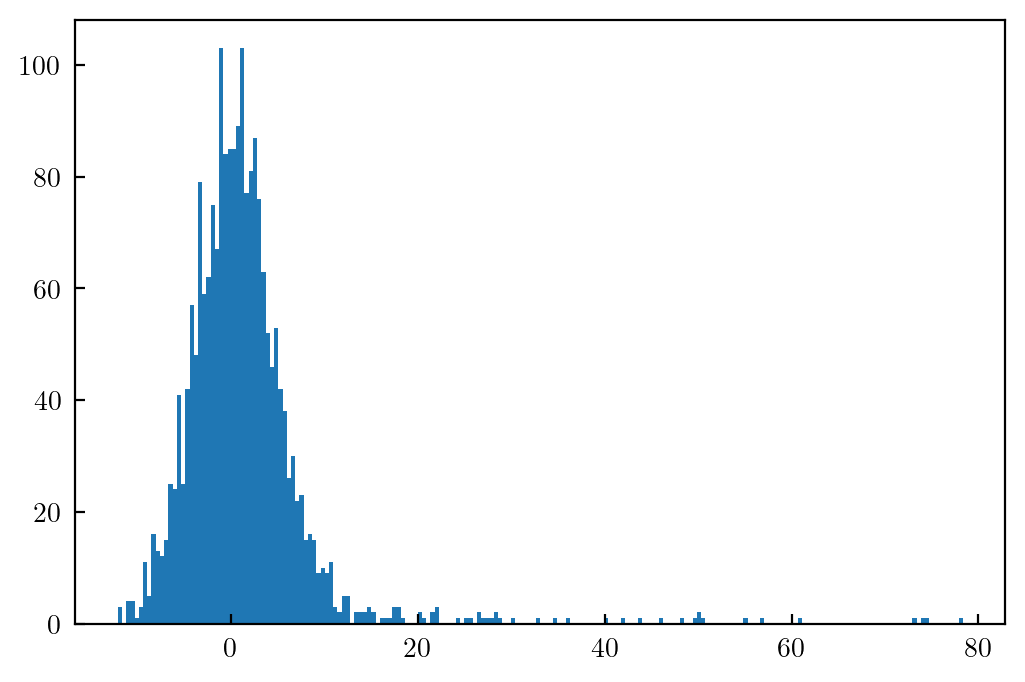

In [26]:
index = 13

values = list(bestfit_table[index])
    
desid = values[0]
    
params = values[1:8]
params = np.array(params)
    
func = values[-1]

imgiter = read_fits_image(os.path.join(path, files[index]))

def plot_hist_pixval(image):
    conimg = np.concatenate(image)
    plt.hist(conimg, bins=200)

plot_hist_pixval(imgiter)

In [30]:
for i in range(16):

    values = list(bestfit_table[i])
    
    desid = values[0]
    
    params = values[1:8]
    params = np.array(params)
    
    func = values[-1]

    imgiter = read_fits_image(os.path.join(path, files[i]))

    # the 93rd percentile is an arbitrary threshold used to conveniently
    # avoid negative I_bg in the uncertainty calculation
    perc95 = np.percentile(imgiter, 95)
        
    # getting background pixels
    inds = (imgiter < perc95)
    bg_pixels = imgiter[inds]
    
    ## I_bg and std_bg
    
    img_bg = np.mean(bg_pixels)
    
    std_bg1 = rms(img_bg)
    
    sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
    
    bg_pixels = sigma_clip(imgiter, masked=False, axis=None)
    
    bkgrms = StdBackgroundRMS(sigma_clip)
    
    std_bg2 = bkgrms(imgiter)
    
    img_bg = np.mean(bg_pixels)
    
    print(i, std_bg1)
    
    ## I_gal
    
    img_gal = imgiter - img_bg          # I_tot = I_gal + I_bg
    
    std_gal = np.sqrt(img_gal)
    
    # set negative I_gal values to 0
    invalid_sgal_ind = (std_gal == np.inf) | (std_gal == -np.inf)
    #print(np.count_nonzero(invalid_sgal_ind))
    std_gal[invalid_sgal_ind] = 0
    
    std_gal = np.nan_to_num(std_gal)
    
    ## estimate uncertainties

    std_arr = np.sqrt(std_gal**2 + std_bg2**2)

0 1.0604604482650757
1 5.198608875274658
2 2.4621782302856445
3 1.871303677558899
4 1.1678056716918945
5 0.7769449949264526
6 2.2669544219970703
7 2.956873655319214
8 0.4603048861026764
9 34.14573287963867
10 0.6180198192596436
11 1.1216862201690674
12 6.193600177764893
13 0.22942684590816498
14 2.629423141479492
15 30.66071891784668


/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt
/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt
/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt
/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt
/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt
/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt
/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt
/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: Ru

(47, 47)


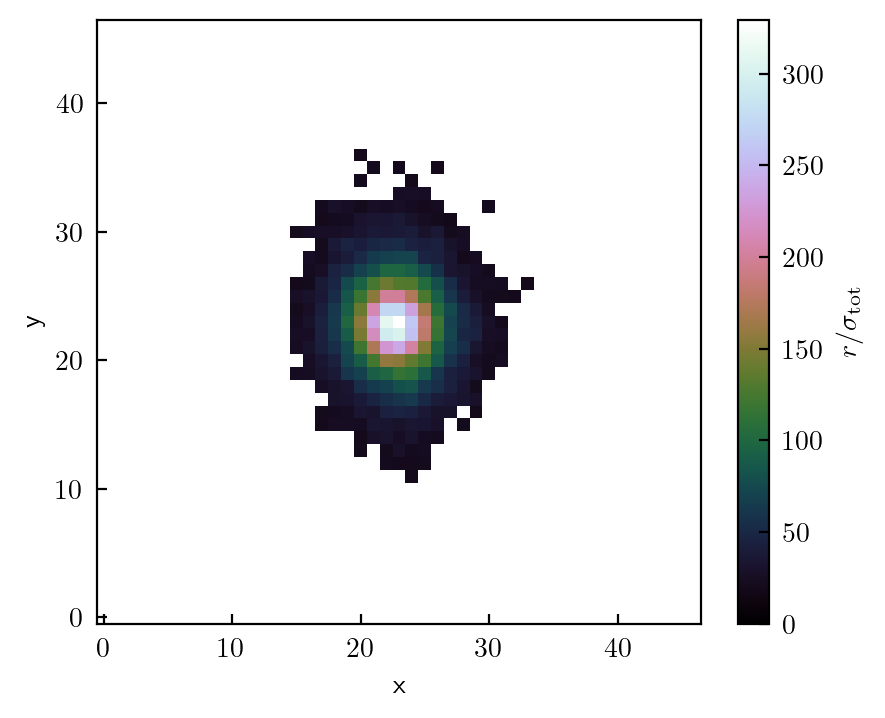

In [31]:
index = 12

imgiter = read_fits_image(os.path.join(path, files[index]))

ub = np.max(imgiter)

# sigma-clipping and photutils.background

sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
    
bg_pixels = sigma_clip(imgiter, masked=False, axis=(0,1))
print(bg_pixels.shape)
    
bkgrms = StdBackgroundRMS(sigma_clip)
    
std_bg = bkgrms(imgiter)

just_gal = imgiter - np.nan_to_num(bg_pixels)
nan_inds = (just_gal < 1e-6)
just_gal[nan_inds] = np.nan

# percent threshold

percent = np.percentile(imgiter, 95)
#print(percent)

img_copy = imgiter.copy()

perc_ind = (imgiter < percent)
img_copy[perc_ind] = np.nan

plt.imshow(just_gal, origin='lower', cmap='cubehelix'#, interpolation='nearest'
           , vmin=0, vmax=ub
          )
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
cbar.set_label(r'$r/\sigma_{\rm tot}$', labelpad=5)
#cbar.set_ticks([-1, 0, 1, 2], update_ticks=True)
plt.show()

/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt


-13.550690506748374 14.156921784523902
-3.429996478954814 2.509914239822676


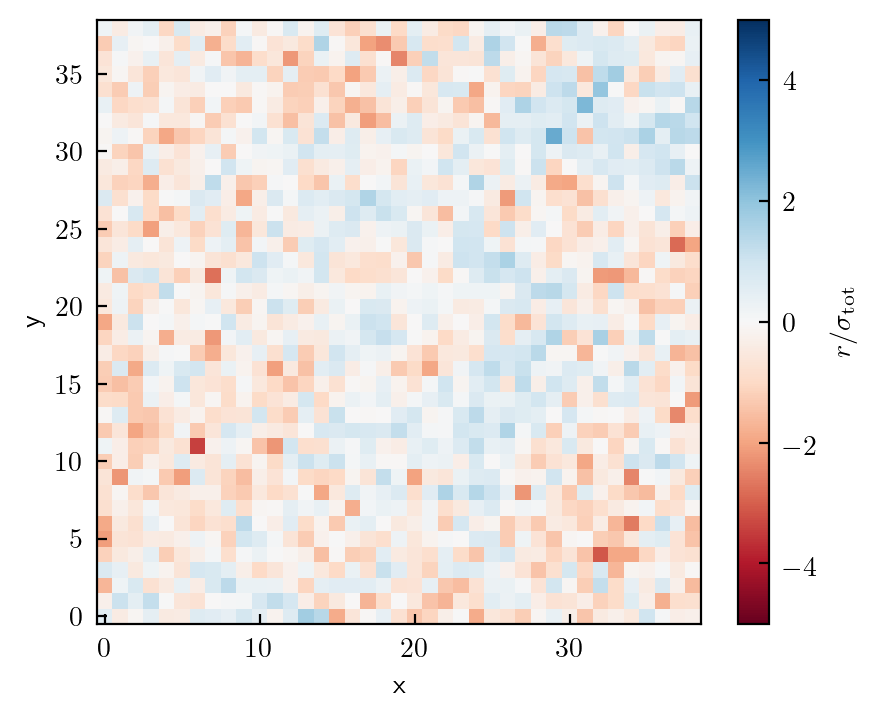

In [32]:
index = 2

values = list(bestfit_table[index])
    
desid = values[0]
    
params = values[1:8]
params = np.array(params)
    
func = values[-1]

imgiter = read_fits_image(os.path.join(path, files[index]))

nrow, ncol = imgiter.shape
x, y = np.meshgrid(np.arange(ncol), np.arange(nrow))

res_img, stds = get_img_uncertainties(imgiter)

row = bestfit_table[index]

'''
params = list(row)[1:8]
params = np.array(params)
'''

ai, ri, ni, x0i, y0i, ei, thi = params.copy()
sersiciter = functional_models.Sersic2D(amplitude=ai, r_eff=ri, n=ni
                                            , x_0=x0i, y_0=y0i
                                            , ellip=ei, theta=thi)

profile = sersiciter(x, y)

#plot_rescaled_residuals(profile, imgiter, index)


total_std = np.sqrt(stds[0]**2 + stds[1]**2)

#diff_img = (imgiter - profile) / total_std
diff_img = (res_img - profile) / stds

#testthing, teststds = get_img_uncertainties(diff_img)
print(np.min(res_img - profile), np.max(res_img - profile))

print(np.min(diff_img), np.max(diff_img))

plt.imshow(diff_img, origin='lower', cmap='RdBu'#, interpolation='nearest'
           , vmin=-5, vmax=5
          )
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
cbar.set_label(r'$r/\sigma_{\rm tot}$', labelpad=5)
#cbar.set_ticks([-1, 0, 1, 2], update_ticks=True)
plt.show()

In [33]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_rescaled_residuals(profile, raw, index):
    
    rescaled_raw, stds = get_img_uncertainties(raw)
    
    des = bestfit_table.copy()[index]['DES_ID']
    
    total_std = np.sqrt(stds[0]**2 + stds[1]**2)

    #diff_img = (rescaled_raw - profile) / total_std
    diff_img = (rescaled_raw - profile) / stds
    
    plt.figure(figsize=(3,3))
    plt.title('{}'.format(des), fontsize=14)
    
    plt.imshow(diff_img, origin='lower', cmap='cubehelix'#, interpolation='nearest'
               , vmin=-5, vmax=5
              )
    plt.xlabel(r'$x$')
    plt.ylabel(r'$y$')
    cbar = plt.colorbar(fraction = 0.046, pad = 0.04)
    cbar.set_label(r'$r / \sigma_{\rm tot}$', labelpad=5)
    
    plt.show()

def plot_raw_profile_rr(profile, raw, index):

    des = bestfit_table.copy()[index]['DES_ID']
    
    galaxy, stds = get_img_uncertainties(raw, num=1.0)
    
    total_std = np.sqrt(stds[0]**2 + stds[1]**2)
    
    diff_img = (galaxy - profile) / stds
    
    fig, ax = plt.subplots(1,3)
    fig.set_figheight(4.5)
    fig.set_figwidth(18)
    
    #fig.suptitle(des, fontsize=20)

    imgs = np.array([galaxy, profile, diff_img])
    
    imgs_min = np.min(imgs, axis=(1,2))
    imgs_max = np.max(imgs, axis=(1,2))
    
    # lower bound not 0 if negative pixel values in des images not removed
    cbar_lb = np.min(imgs_min[:2]) - 40
    cbar_ub = np.max(imgs_max[:2])

    #ax[0].set_title(r'DES redMaGiC Galaxy $I_{\rm gal}$ \nDES ID: {}'.format(des), fontsize=18)
    ax[0].set_title(r'$I_{\rm gal}$, DES ID: ' + des, fontsize=18)
    ax[1].set_title(r'$I(\mathbf{v})$, Fitted Sérsic Profile', fontsize=18)
    ax[2].set_title(r'$\left( I_{\rm gal} - I(\mathbf{v}) \right) / \sigma$', fontsize=18)

    ax[0].set_ylabel(r'$y$', fontsize=18)
    
    for i, image in enumerate(imgs):
    
        if i == 2:
            im = ax[i].imshow(image, origin='lower', cmap='RdBu', interpolation='nearest'
                          , vmin=-5, vmax=5
                         )
            
            divider = make_axes_locatable(ax[i])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            cbar = fig.colorbar(im, cax=cax)
            cbar.set_label('Residual', rotation=270, labelpad=25, fontsize=16)
        
        else:
            im = ax[i].imshow(image, origin='lower', cmap='cubehelix', interpolation='nearest'  # cmap = cubehelix, viridis
                          , vmin=cbar_lb, vmax=cbar_ub
                         )
            
            divider = make_axes_locatable(ax[i])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            cbar = fig.colorbar(im, cax=cax)
            cbar.set_label('Brightness', rotation=270, labelpad=25, fontsize=16)
            
        ax[i].tick_params(axis='both', which='major', labelsize=16)
        ax[i].tick_params(axis='both', which='minor', labelsize=16)
        ax[i].set_xlabel(r'$x$', fontsize=18)

DES0439-5331
---------------------------

minimum at:

   amplitude =  64.5202899345013
   r_eff     =  3.736446288075085
   n         =  0.729179188151665
   x_0       =  20.395912406132553
   y_0       =  19.676322501867222
   ellip     =  0.38798122085599906
   theta     =  4.373351232588691

E2 = 0.7908548854317072



DES0327-4831
---------------------------

minimum at:

   amplitude =  83.36737137288233
   r_eff     =  4.315048097967343
   n         =  1.002997519746169
   x_0       =  22.514858043203287
   y_0       =  22.744486389889797
   ellip     =  0.16694014639649518
   theta     =  4.225327714461011

E2 = 0.642212030835495





/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt
/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt


DES0558-5540
---------------------------

minimum at:

   amplitude =  58.45805298781812
   r_eff     =  3.4735766093601823
   n         =  0.8669263280772395
   x_0       =  19.273626124403897
   y_0       =  19.312683483057615
   ellip     =  0.018730164679515614
   theta     =  4.776216532615422

E2 = 0.6837046374914736



DES0048-4540
---------------------------

minimum at:

   amplitude =  75.57857276045243
   r_eff     =  4.046659109435678
   n         =  0.8340283221687561
   x_0       =  24.018272765178686
   y_0       =  24.311933327594446
   ellip     =  0.21203743667256594
   theta     =  0.49144262305677267

E2 = 0.753346442633157





/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt
/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt


DES0343-4331
---------------------------

minimum at:

   amplitude =  73.88851437870697
   r_eff     =  4.336836819881288
   n         =  0.6076236360422905
   x_0       =  24.93843533682245
   y_0       =  25.362816270941693
   ellip     =  0.19744881884705812
   theta     =  4.109477929807287

E2 = 0.7865428608800729



DES0431-4249
---------------------------

minimum at:

   amplitude =  37.93772419310603
   r_eff     =  3.263395743417751
   n         =  0.876241729766019
   x_0       =  25.11727270221343
   y_0       =  25.12709572696164
   ellip     =  0.03975760627862963
   theta     =  3.7194035604722573

E2 = 0.7555999728918177





/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt
/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt


DES0031-5831
---------------------------

minimum at:

   amplitude =  89.37145294032399
   r_eff     =  3.853042802705074
   n         =  0.7182598342895739
   x_0       =  17.733645950759893
   y_0       =  17.57637217647827
   ellip     =  0.38644785392319003
   theta     =  2.568563899741837

E2 = 0.7432809368602676



DES2318-5540
---------------------------

minimum at:

   amplitude =  94.97980988580704
   r_eff     =  3.315341000678717
   n         =  0.9136023895152289
   x_0       =  19.427649698842583
   y_0       =  18.95520192938083
   ellip     =  0.10595663199208771
   theta     =  3.04190047601392

E2 = 0.6724155984353477





/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt
/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt


DES0432-4706
---------------------------

minimum at:

   amplitude =  31.469430616678967
   r_eff     =  3.754363957599483
   n         =  0.7471267599075003
   x_0       =  22.742195517732917
   y_0       =  23.38608288018339
   ellip     =  0.1261668535659676
   theta     =  4.435210354551632

E2 = 0.7486705851976883



DES2258-5831
---------------------------

minimum at:

   amplitude =  238.38199540027733
   r_eff     =  5.145084288002106
   n         =  0.7794767903741577
   x_0       =  18.310068315883125
   y_0       =  17.598014497948277
   ellip     =  0.15948930018534802
   theta     =  1.4107287824281647

E2 = 0.3832159405210635



/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt
/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt




DES0421-4457
---------------------------

minimum at:

   amplitude =  56.17254539801193
   r_eff     =  3.2019117123589815
   n         =  0.7227089162538193
   x_0       =  23.983965305807462
   y_0       =  24.430627021761996
   ellip     =  0.14491076289699886
   theta     =  1.6763181274514252

E2 = 0.7790470070290736



DES2111-5040
---------------------------

minimum at:

   amplitude =  44.45383837733145
   r_eff     =  3.9104849157101453
   n         =  0.6589513585387784
   x_0       =  21.532630241339096
   y_0       =  22.076445673741695
   ellip     =  0.027373743097527912
   theta     =  1.939279567439014

E2 = 0.7255335563536415



/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt
/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt




DES0137-4748
---------------------------

minimum at:

   amplitude =  76.64356397526996
   r_eff     =  5.084859488977961
   n         =  1.0202790611215167
   x_0       =  22.719367992651442
   y_0       =  22.839288859564693
   ellip     =  0.1989639691393945
   theta     =  4.855028623471791

E2 = 0.6140066285977922



DES0049-4914
---------------------------

minimum at:

   amplitude =  27.744824228263727
   r_eff     =  2.8200654227263886
   n         =  0.7430732831462576
   x_0       =  22.506762139140218
   y_0       =  22.677226763801727
   ellip     =  0.03757547254229369
   theta     =  2.2783237064624347

E2 = 0.8154220525444426



/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt
/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt




DES2144-5205
---------------------------

minimum at:

   amplitude =  45.644527770403485
   r_eff     =  4.006121247025796
   n         =  0.8846922822614348
   x_0       =  20.999706265802992
   y_0       =  21.321492306201066
   ellip     =  0.19457600083643728
   theta     =  2.478630169161214

E2 = 0.708059653736818



DES2313-5457
---------------------------

minimum at:

   amplitude =  172.5496967720872
   r_eff     =  5.900407806940008
   n         =  0.8871906229367411
   x_0       =  19.148932827118134
   y_0       =  19.461794477924467
   ellip     =  0.2616137472899254
   theta     =  3.843905620938778

E2 = 0.44687587128309064



/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt
/Users/aidan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in sqrt


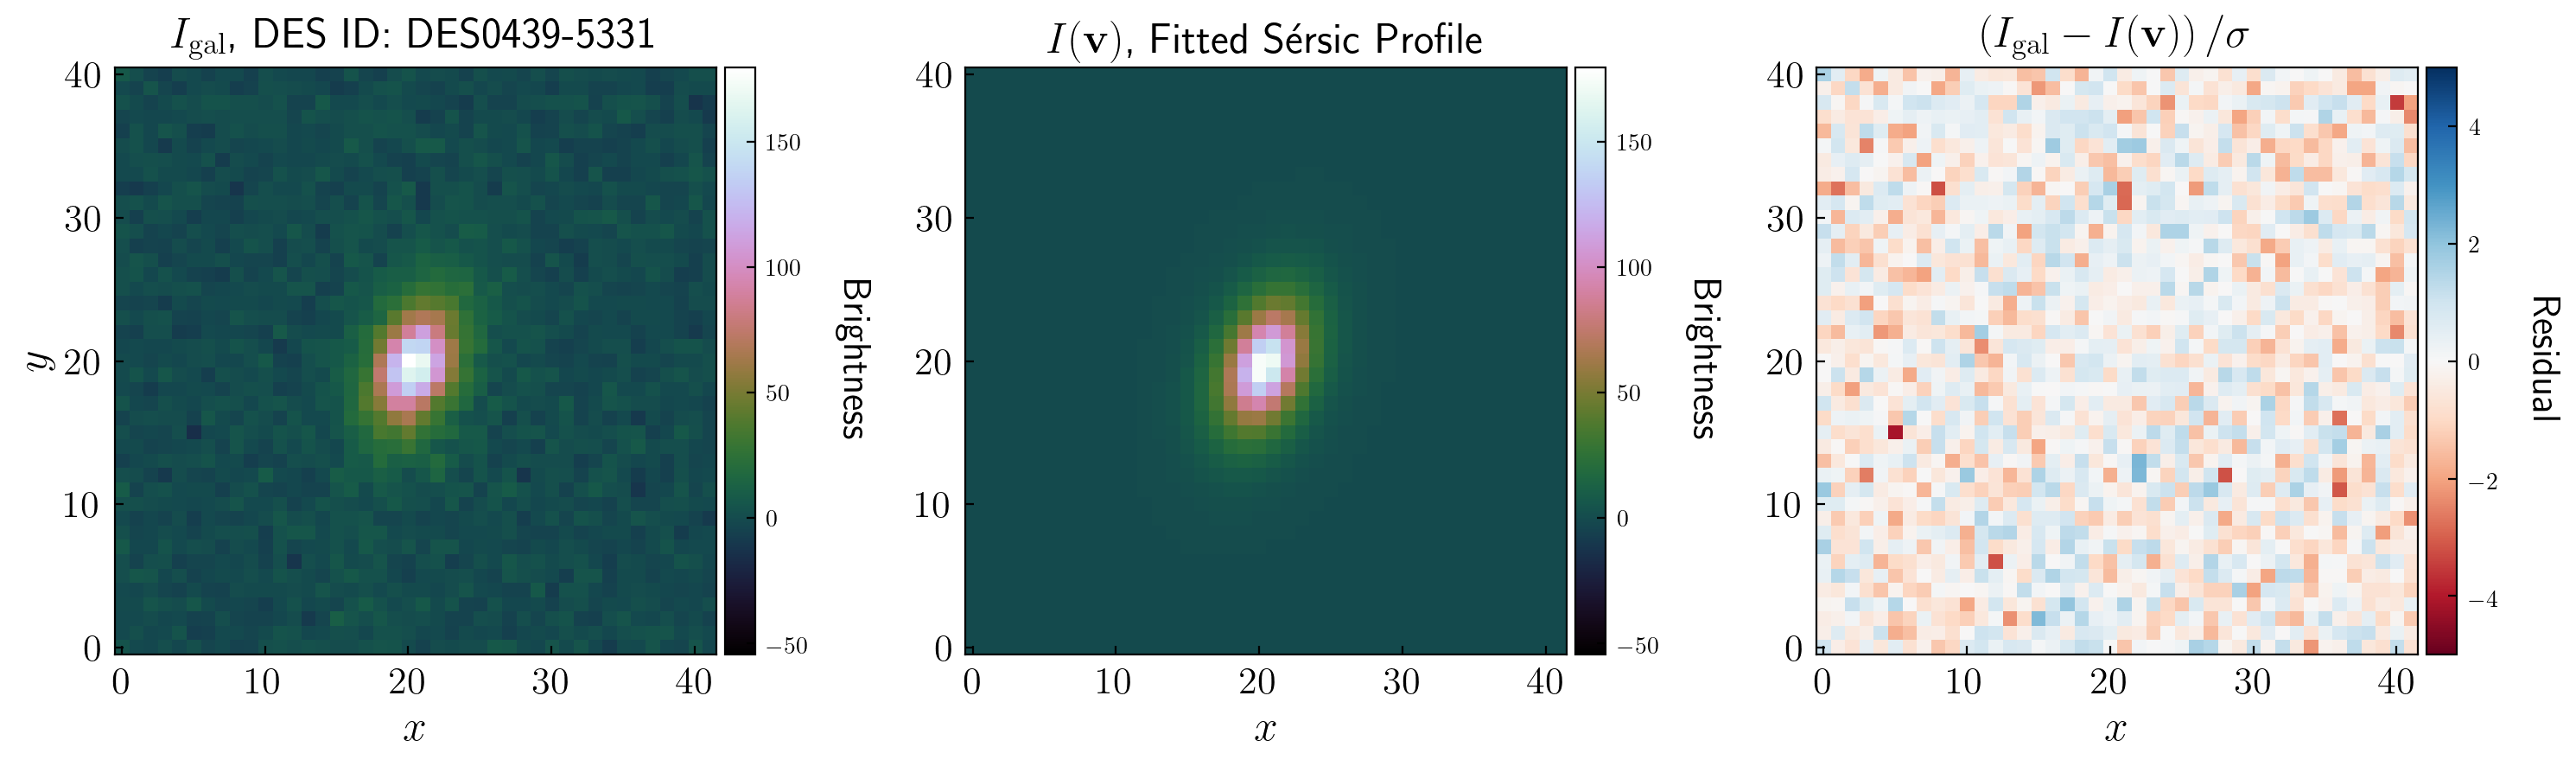

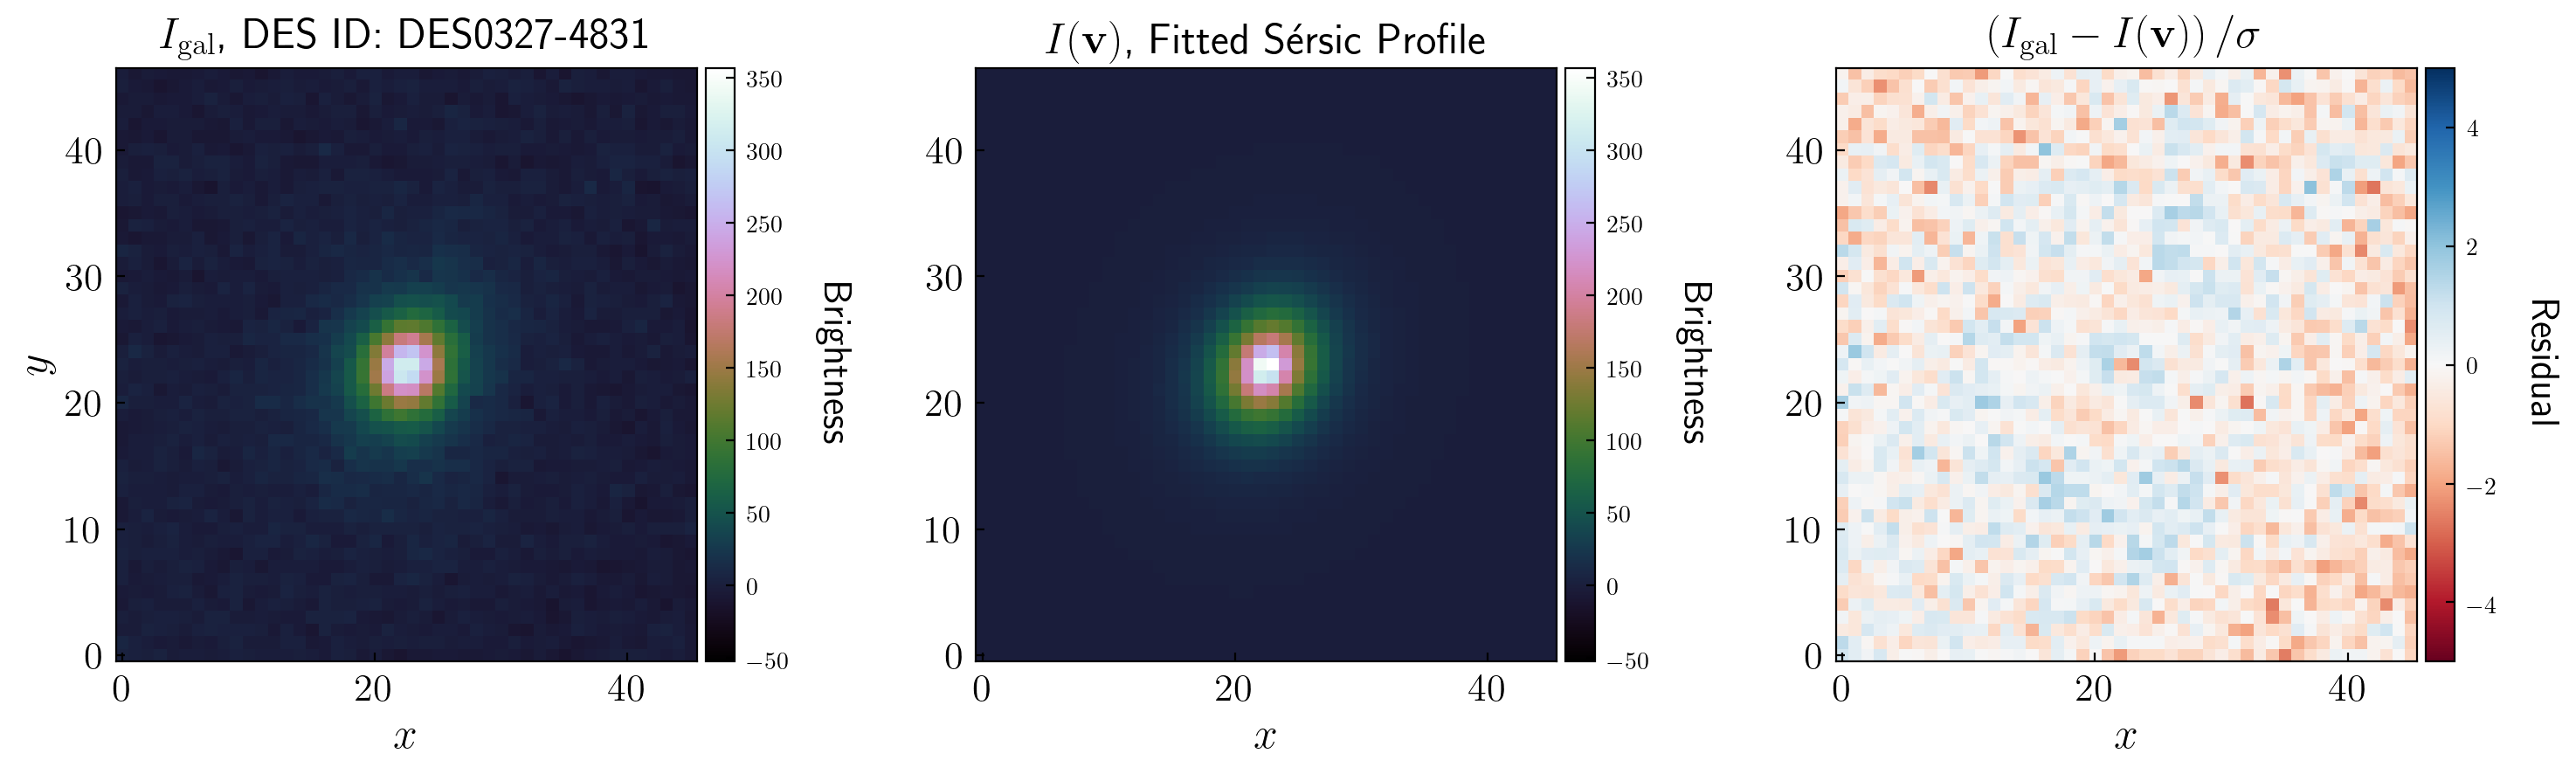

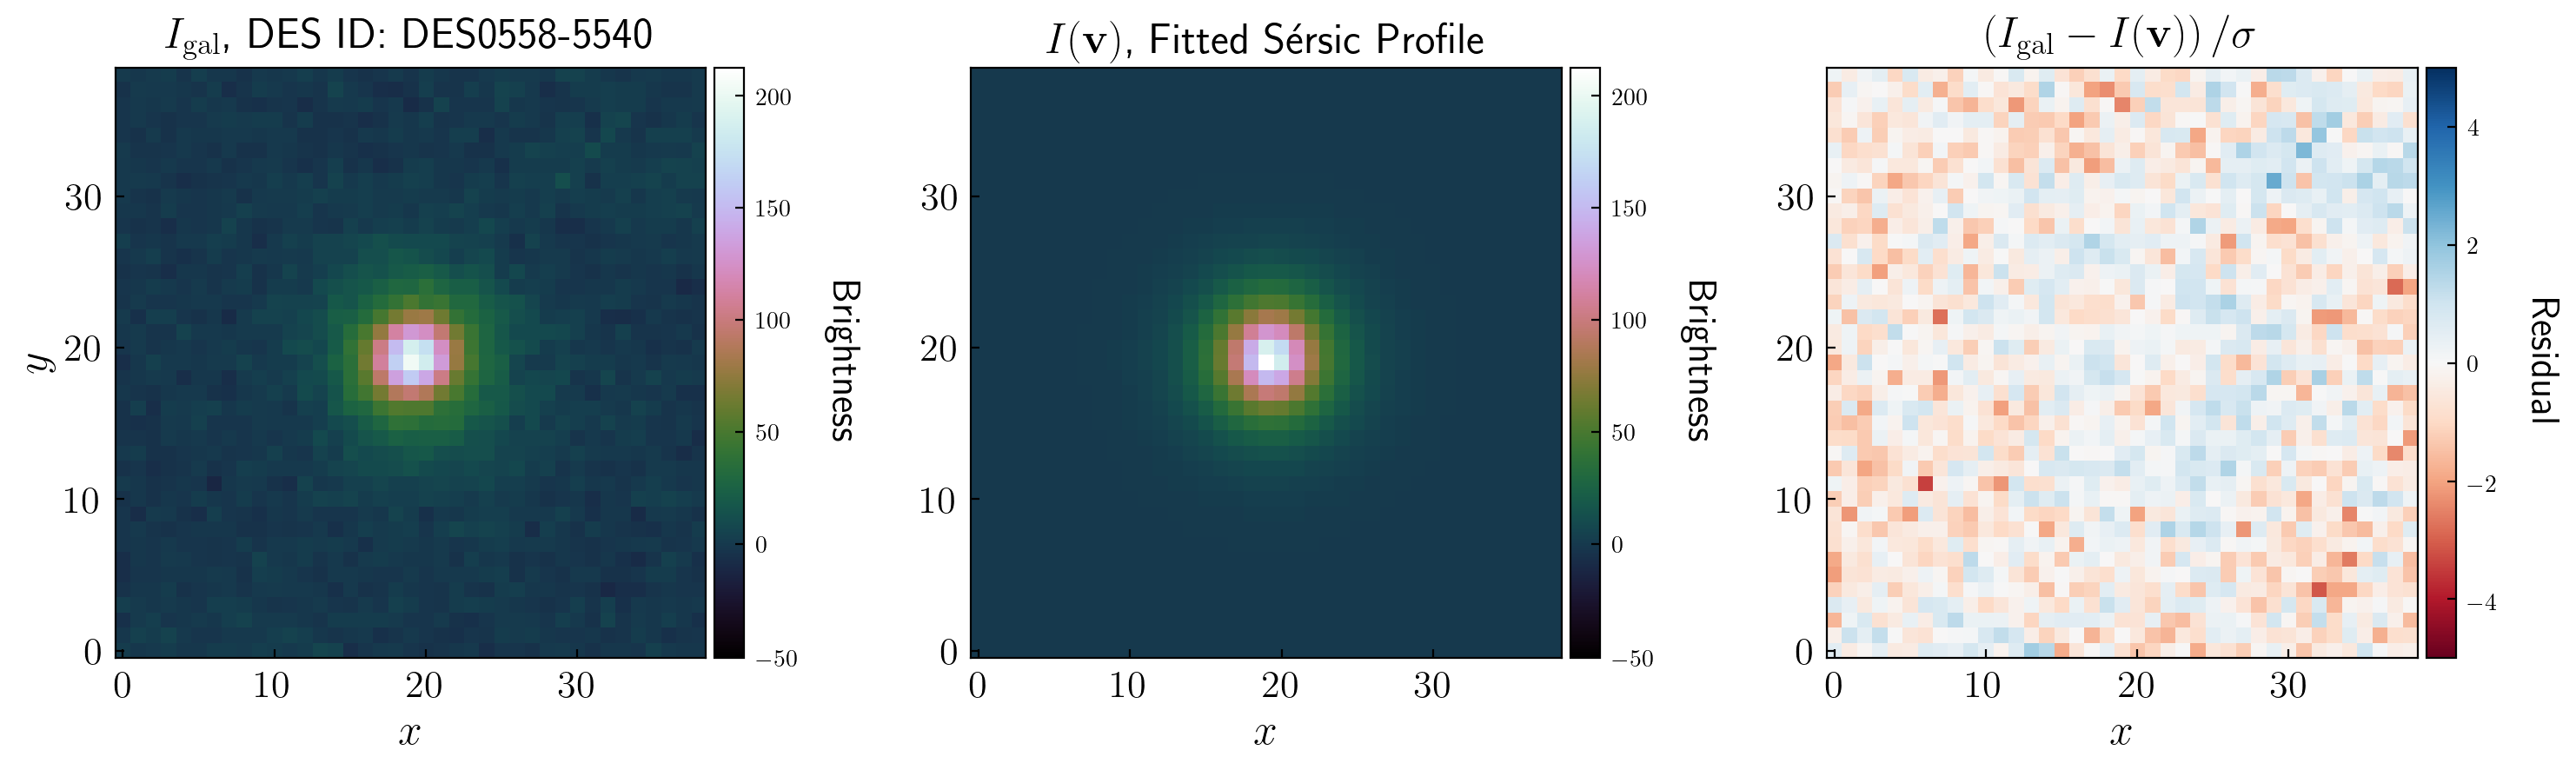

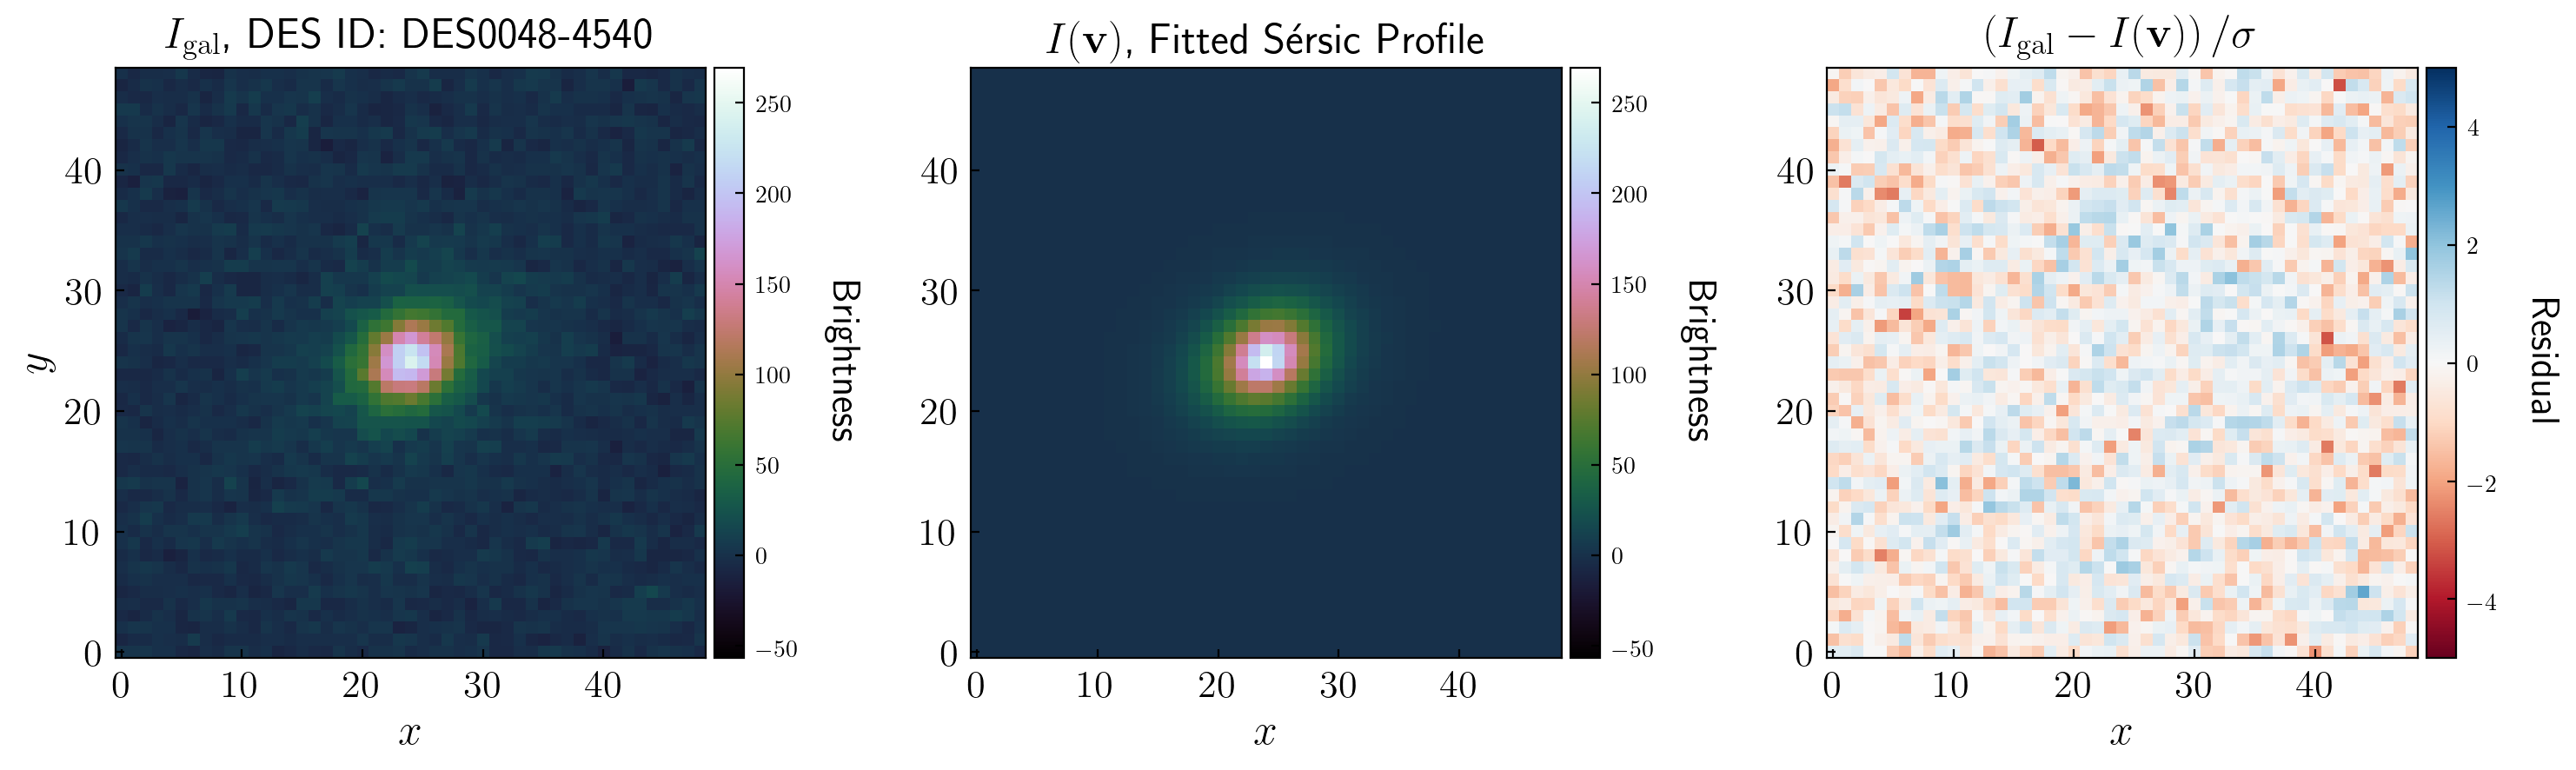

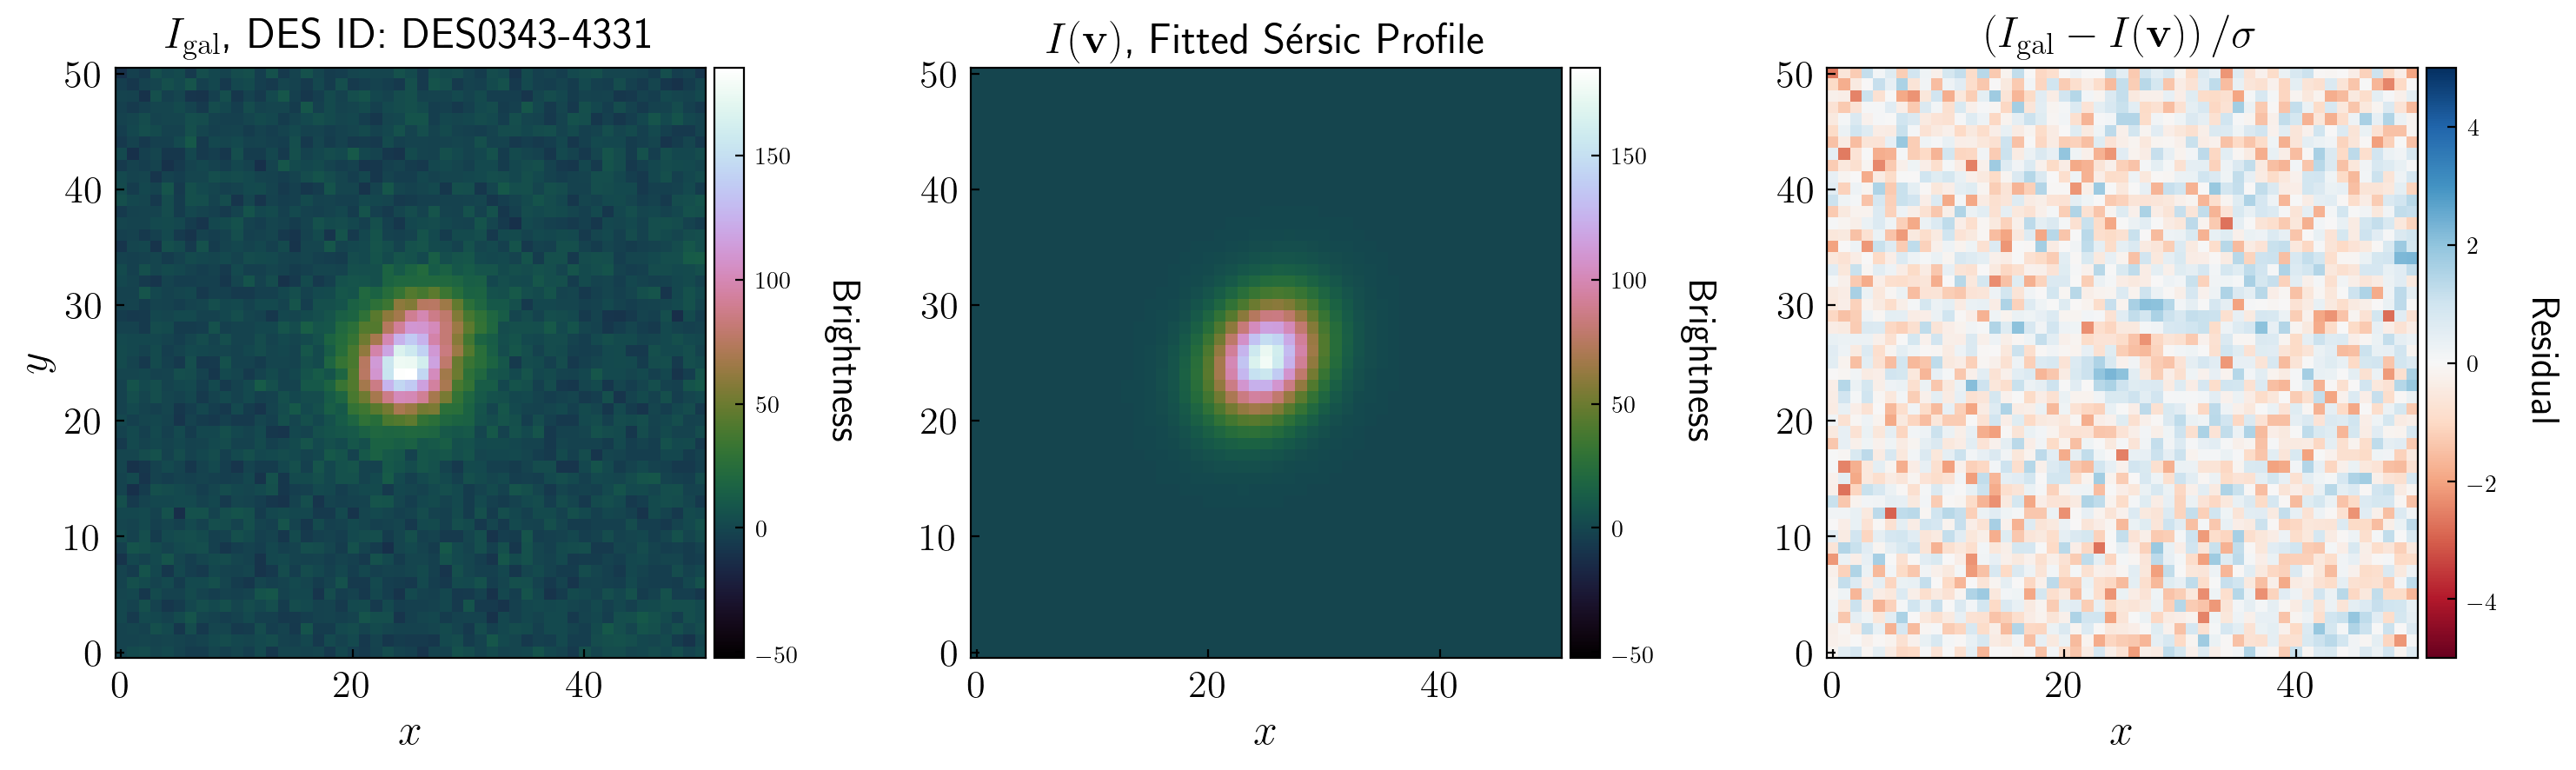

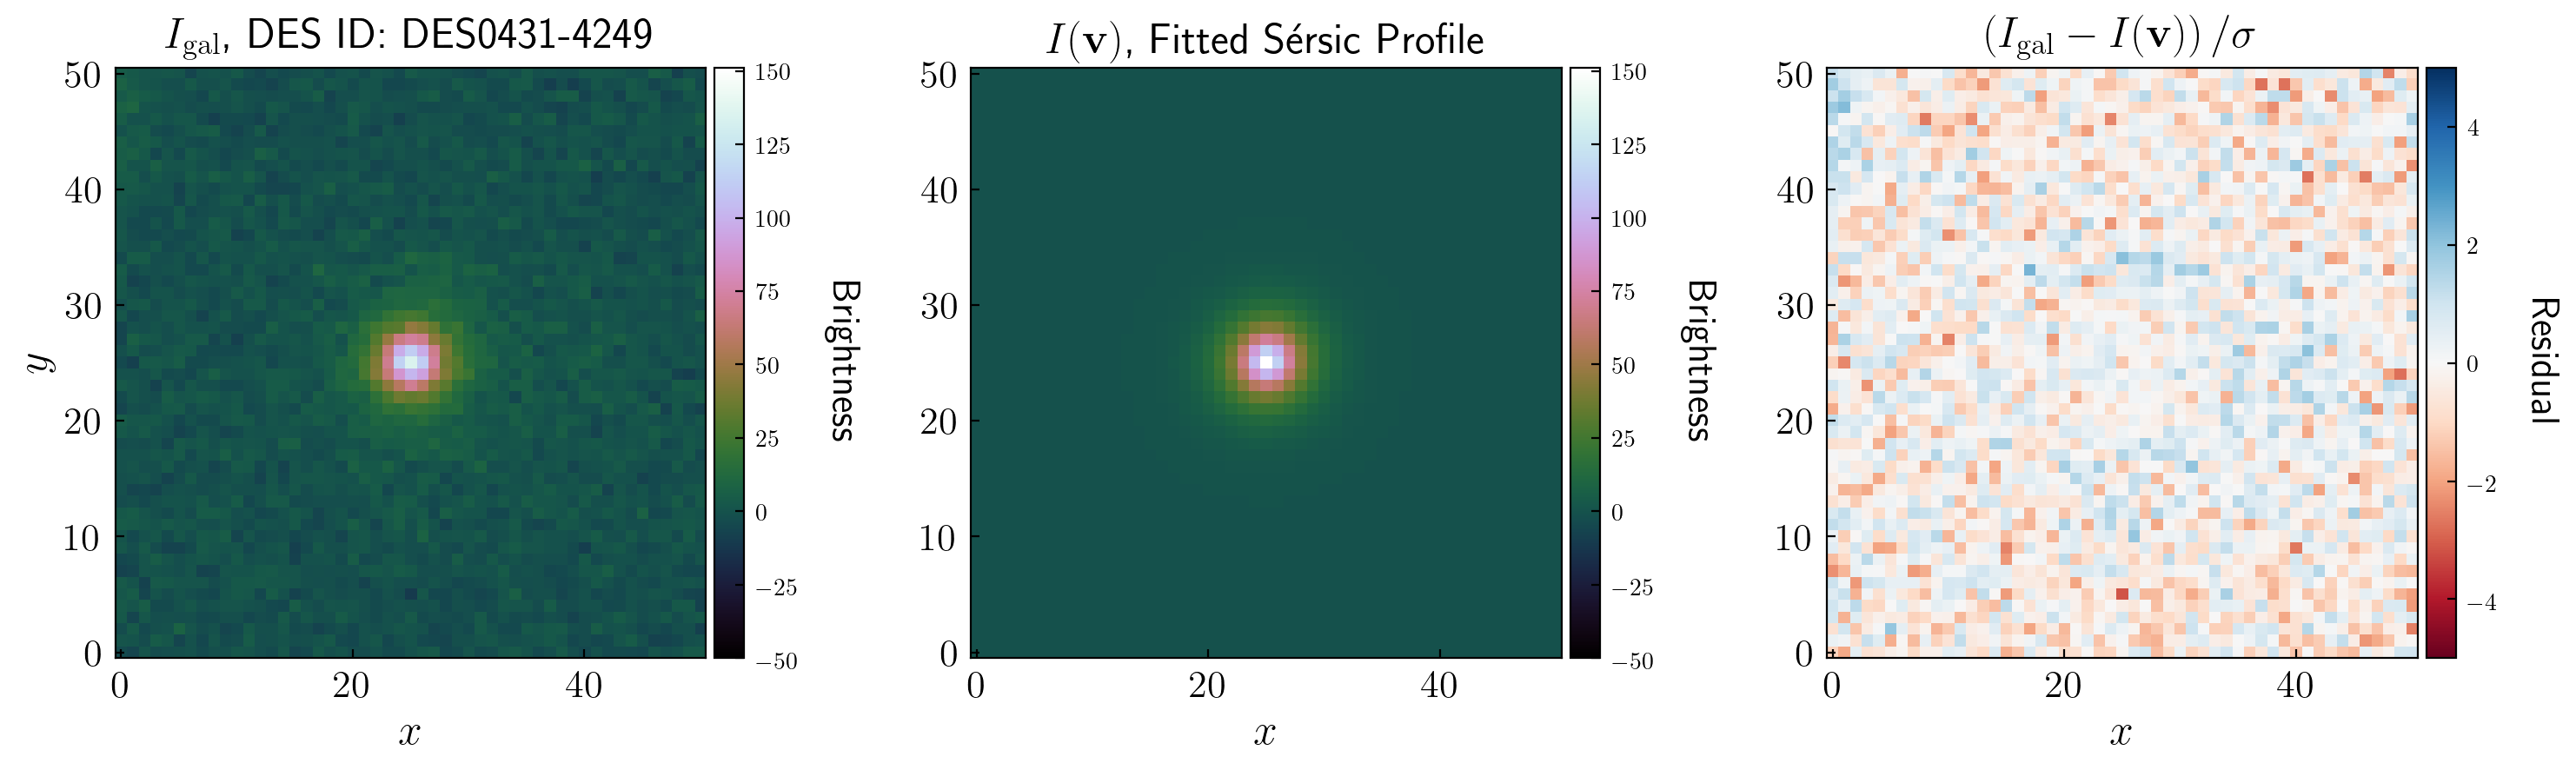

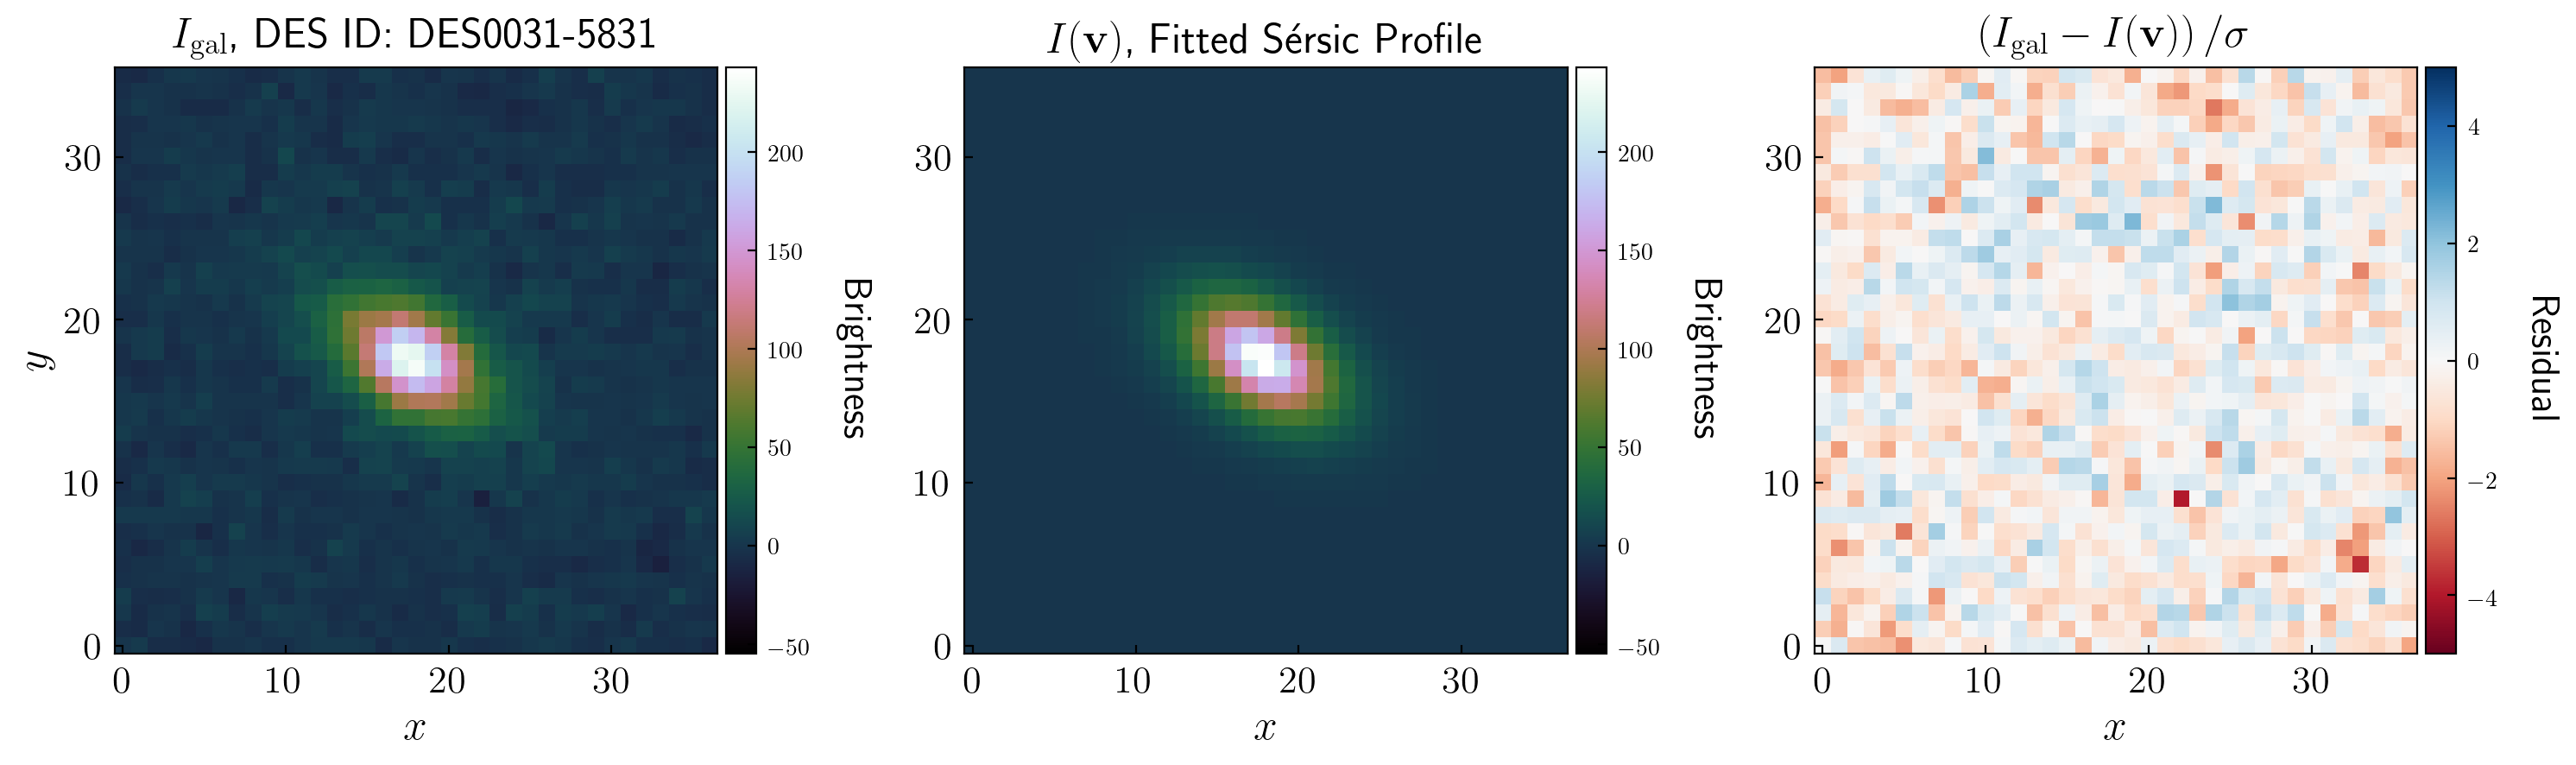

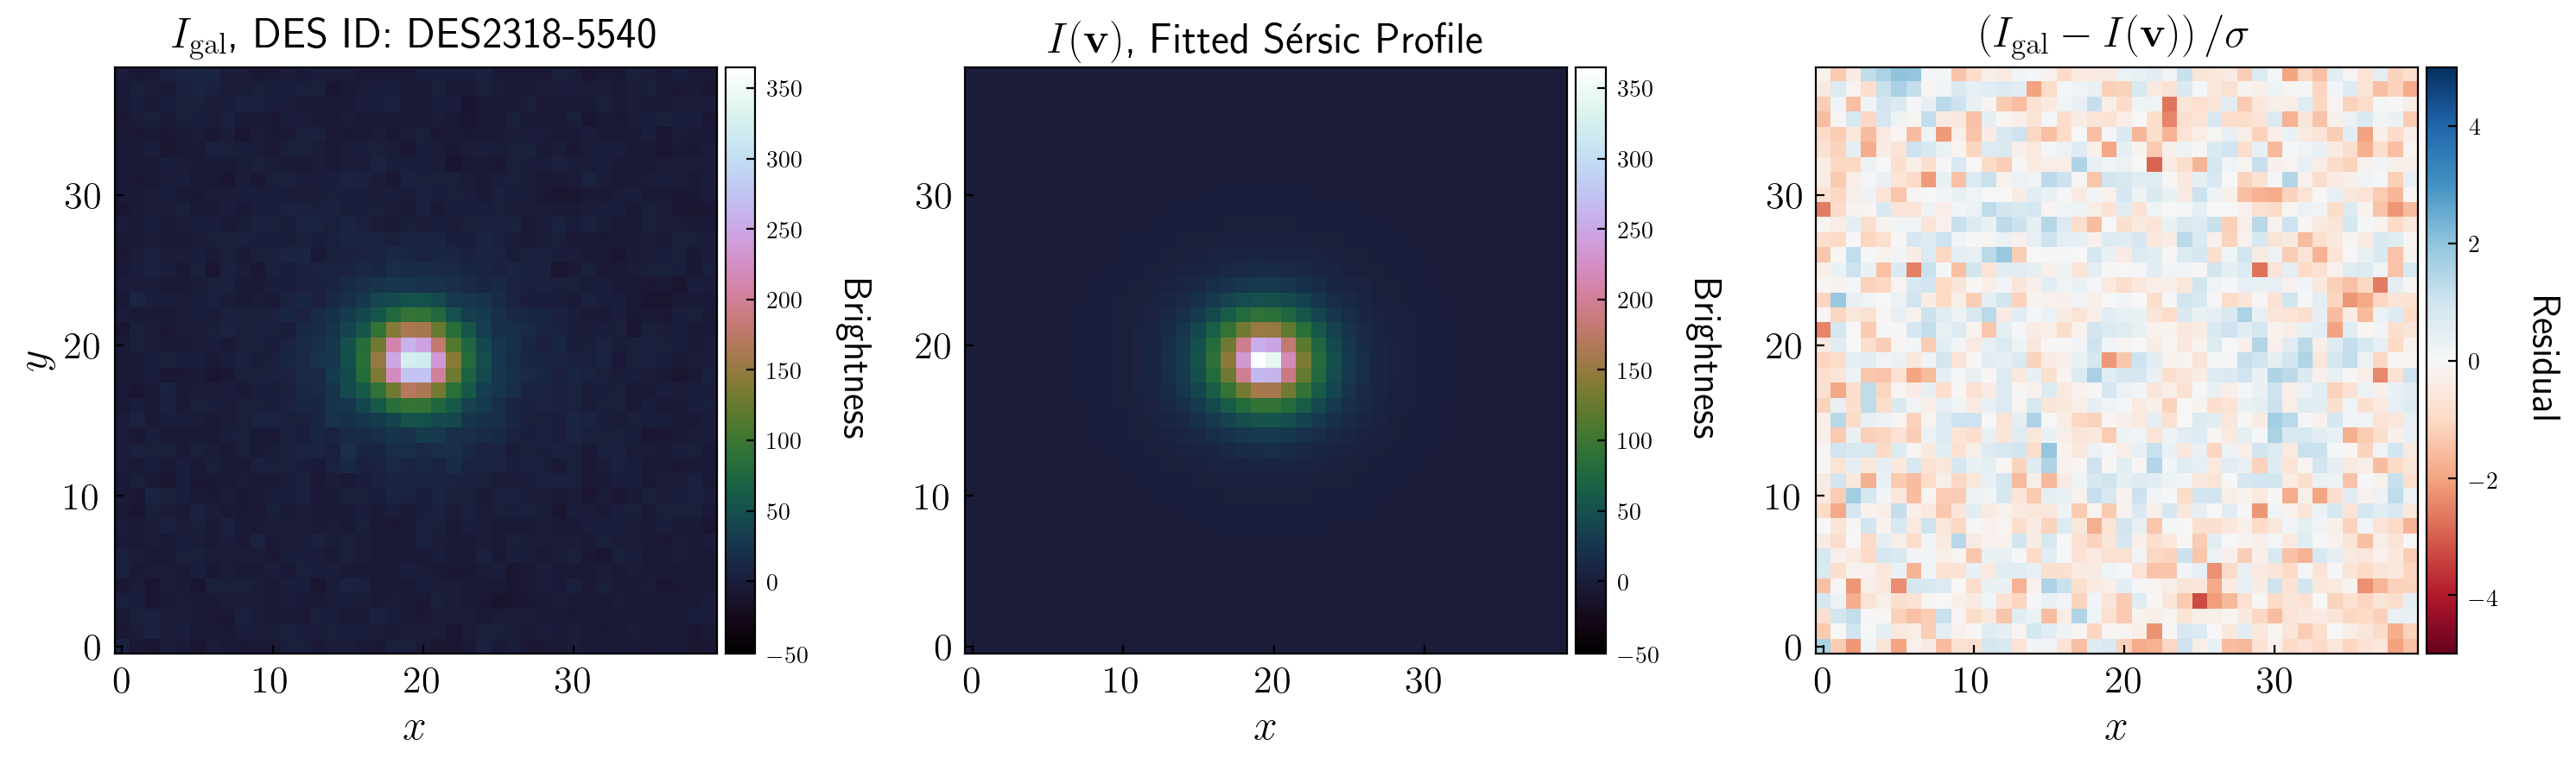

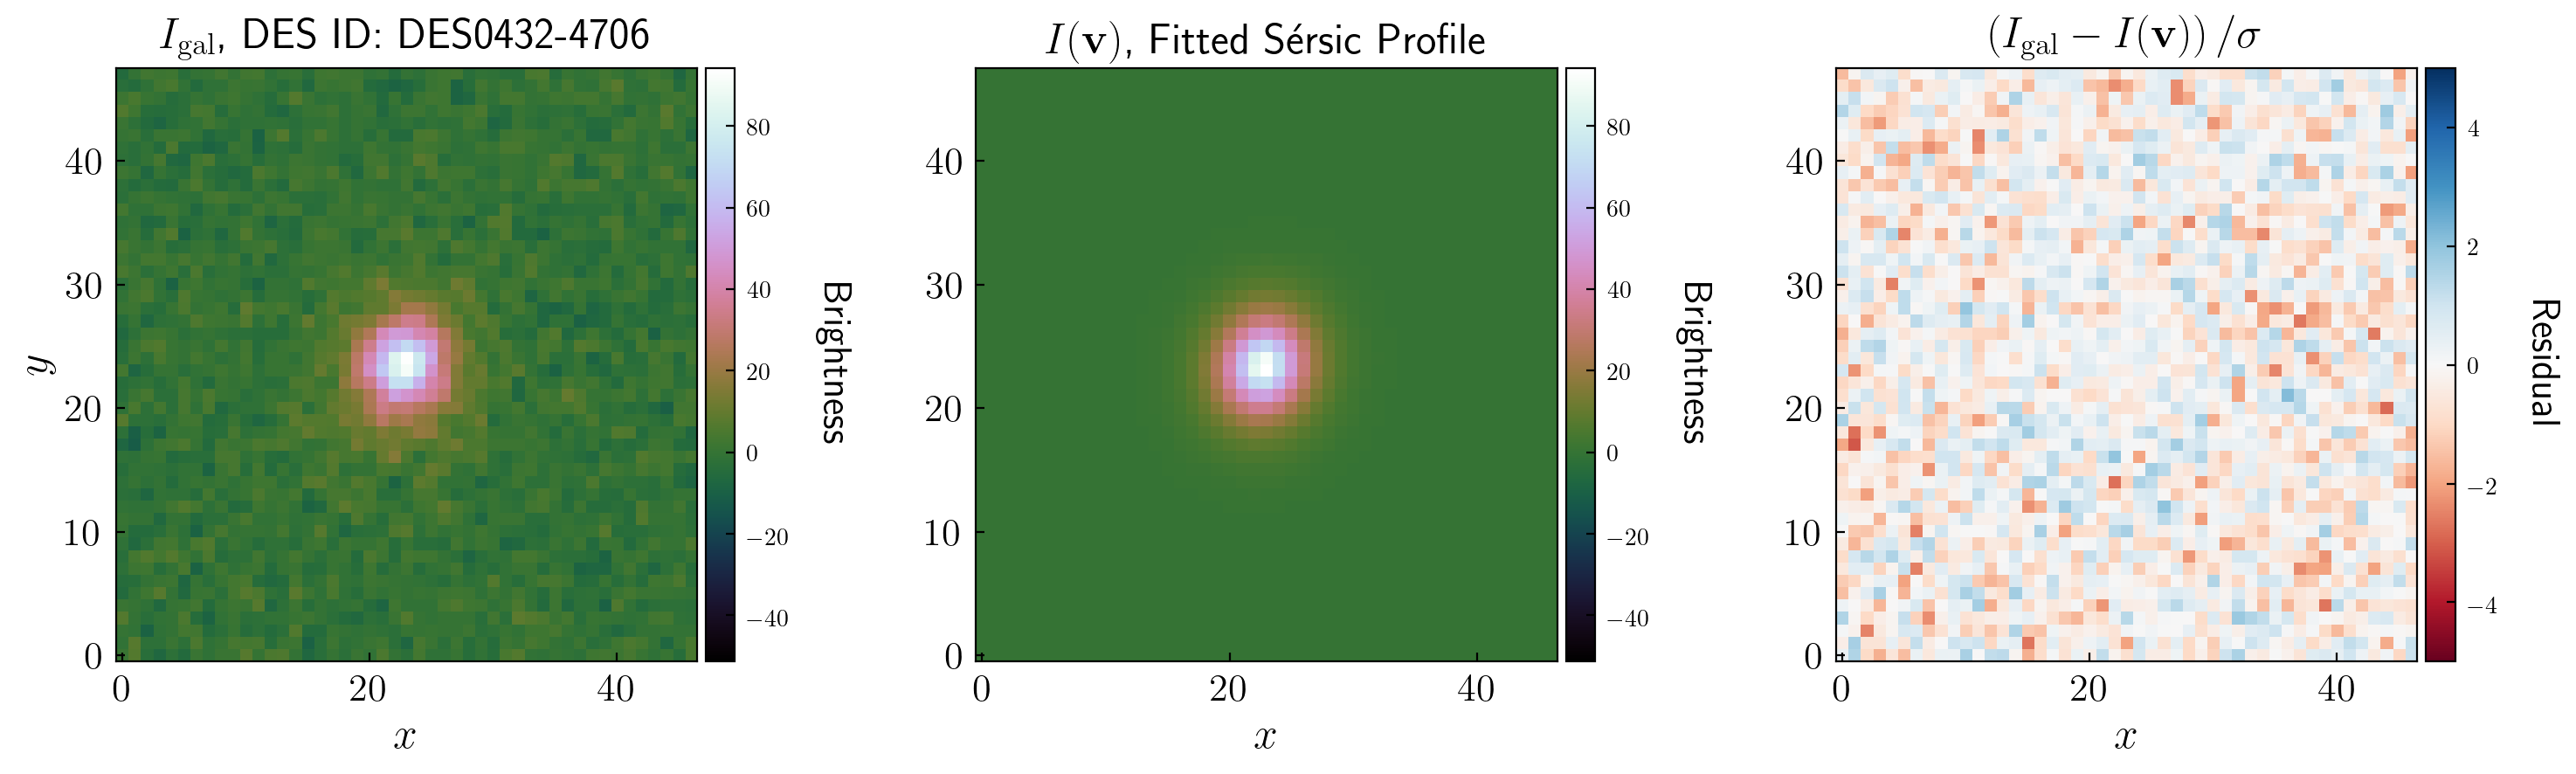

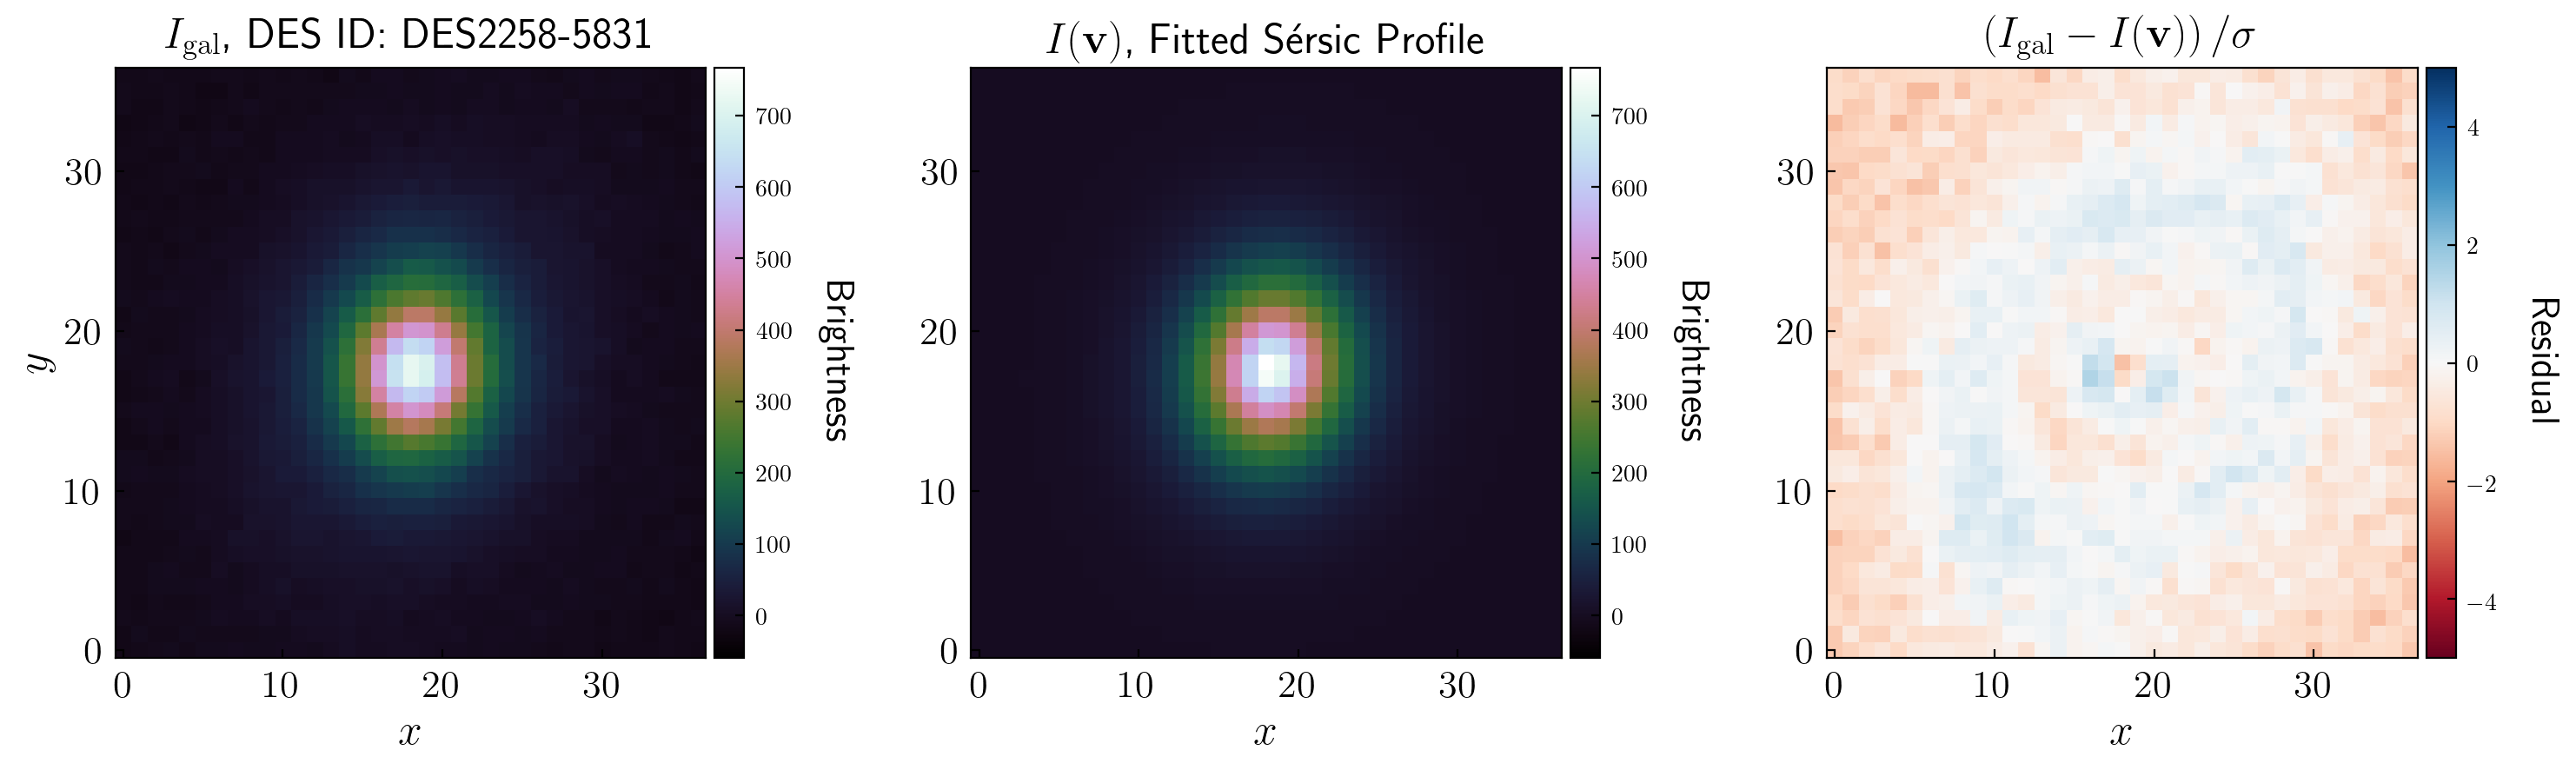

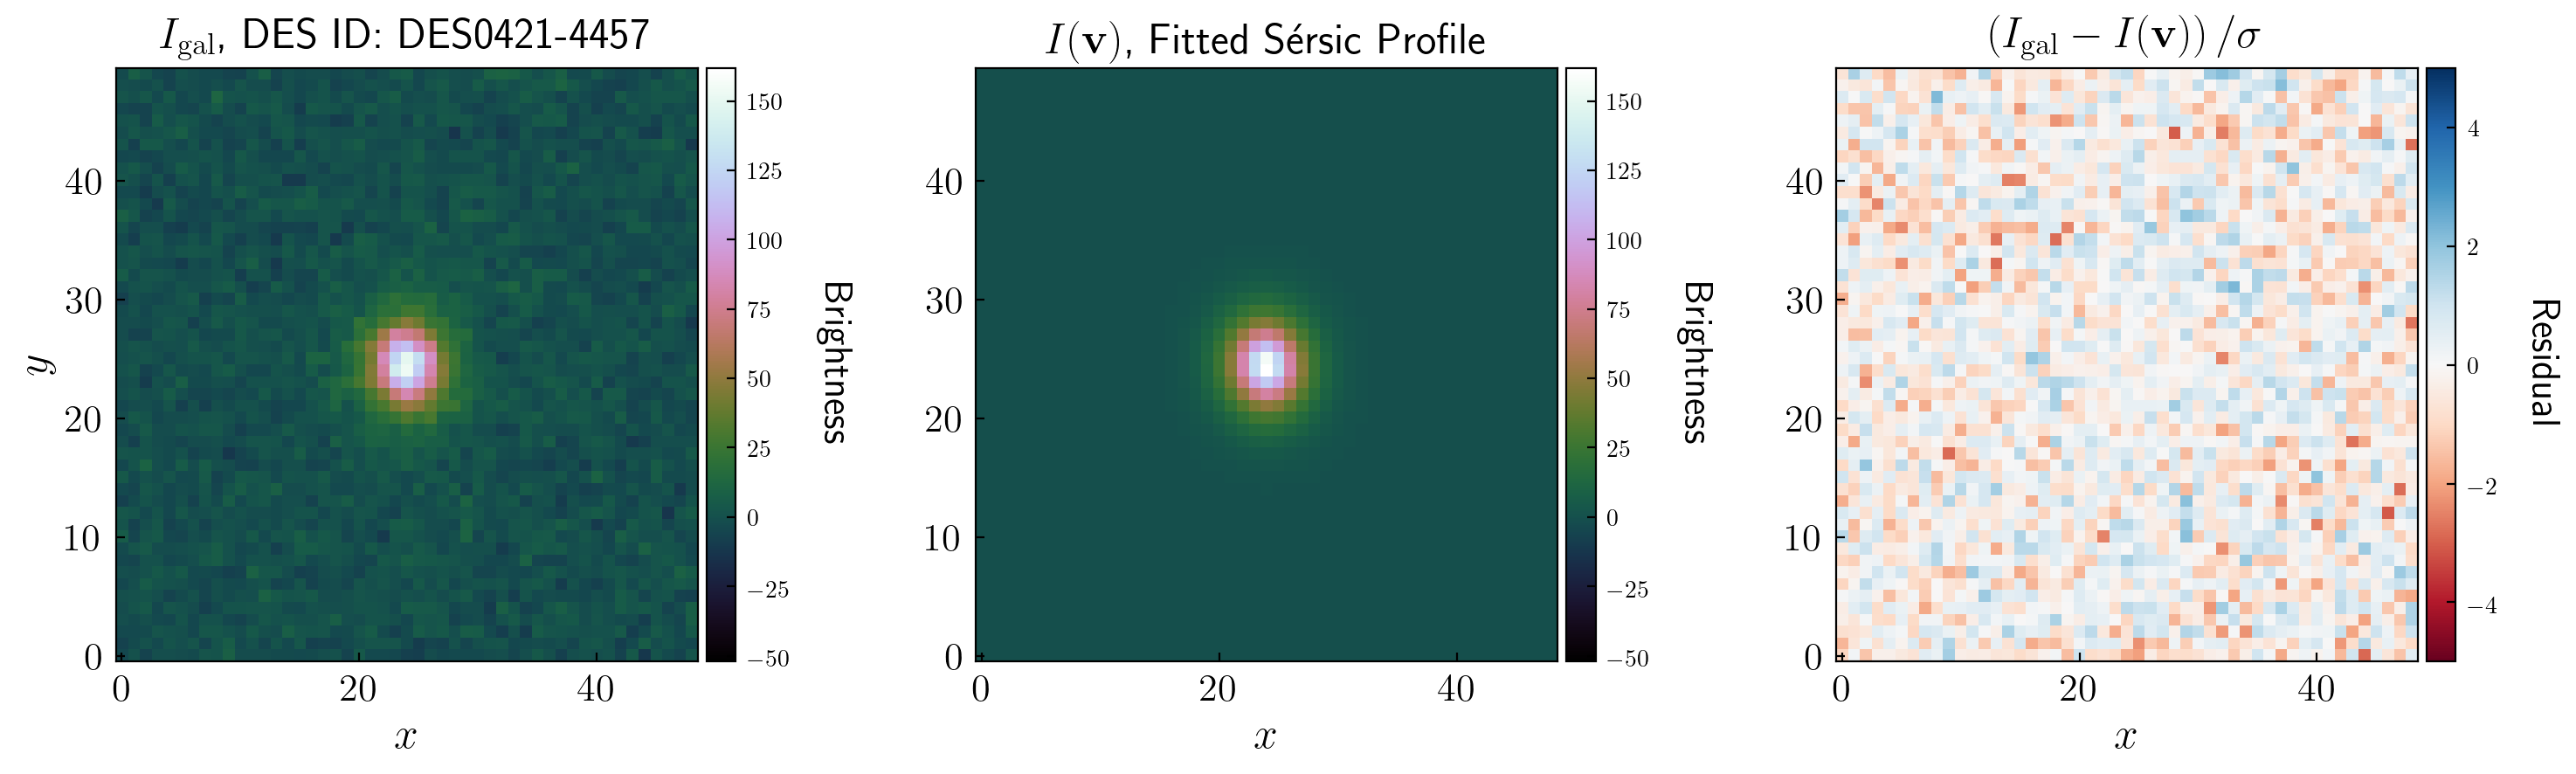

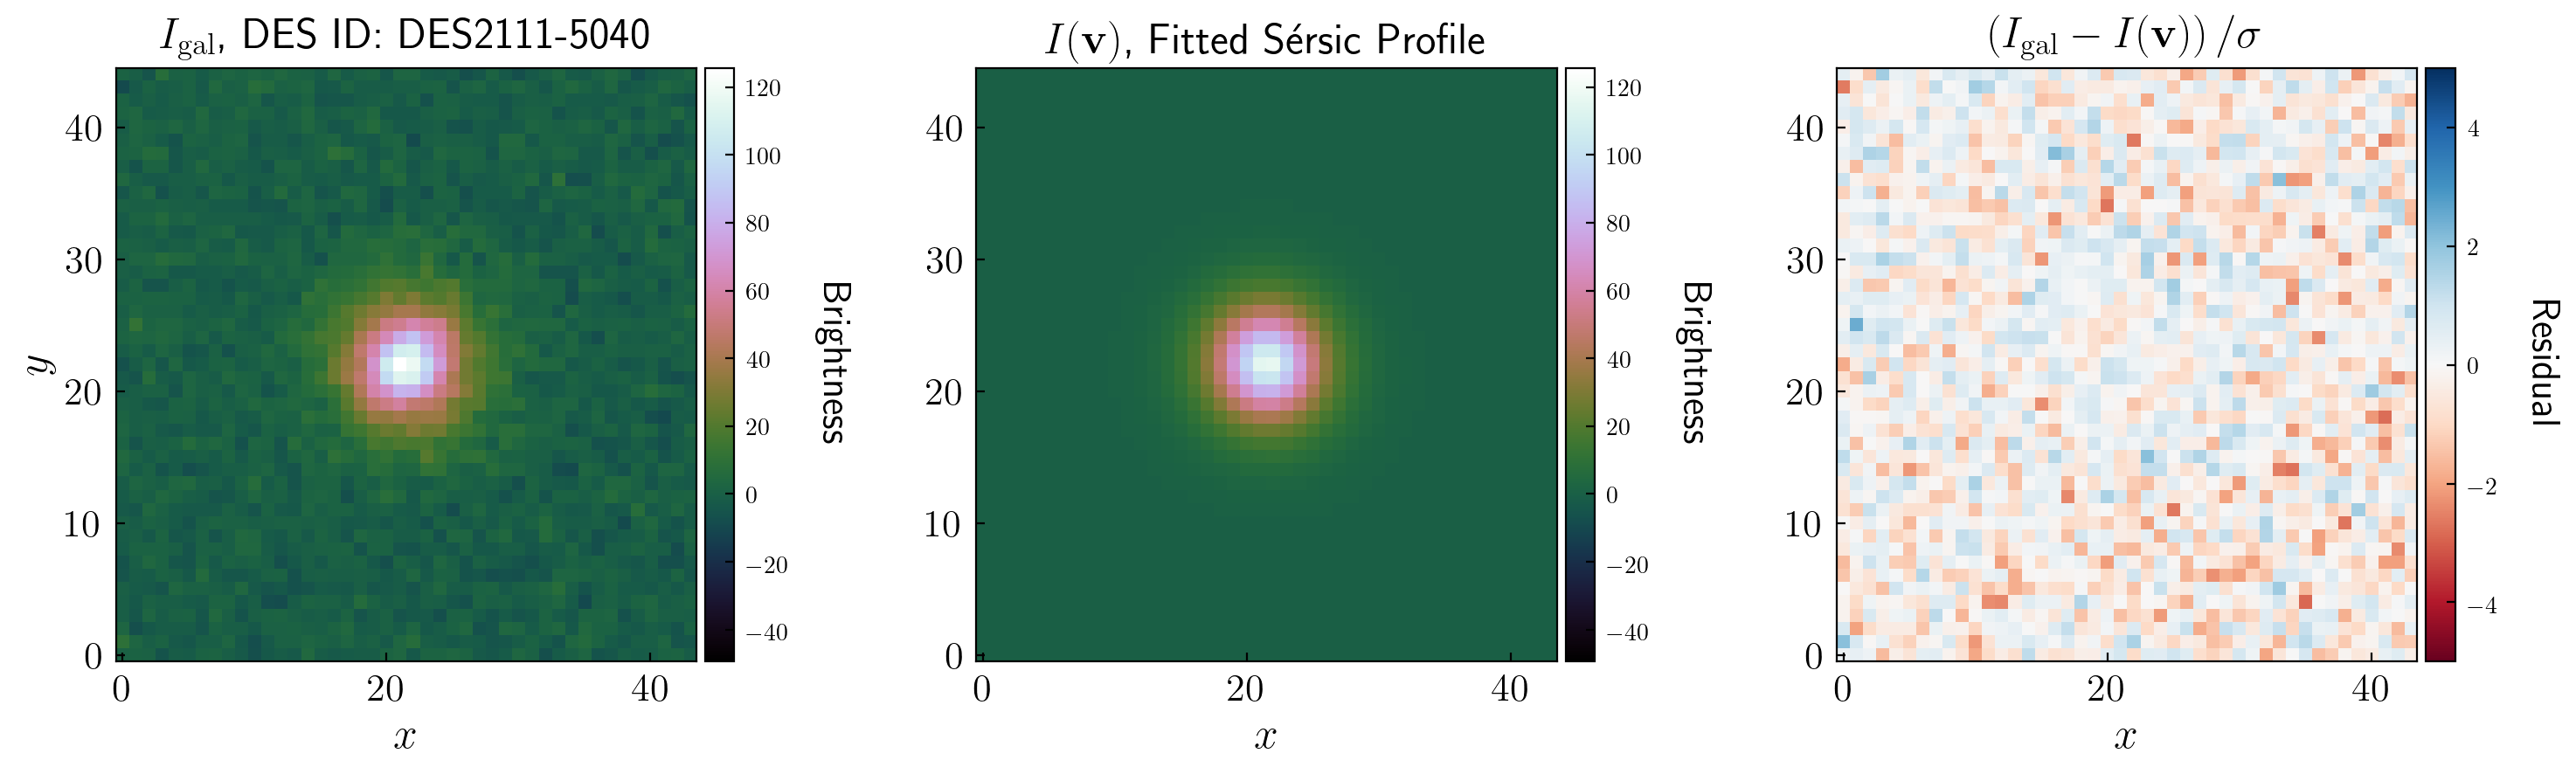

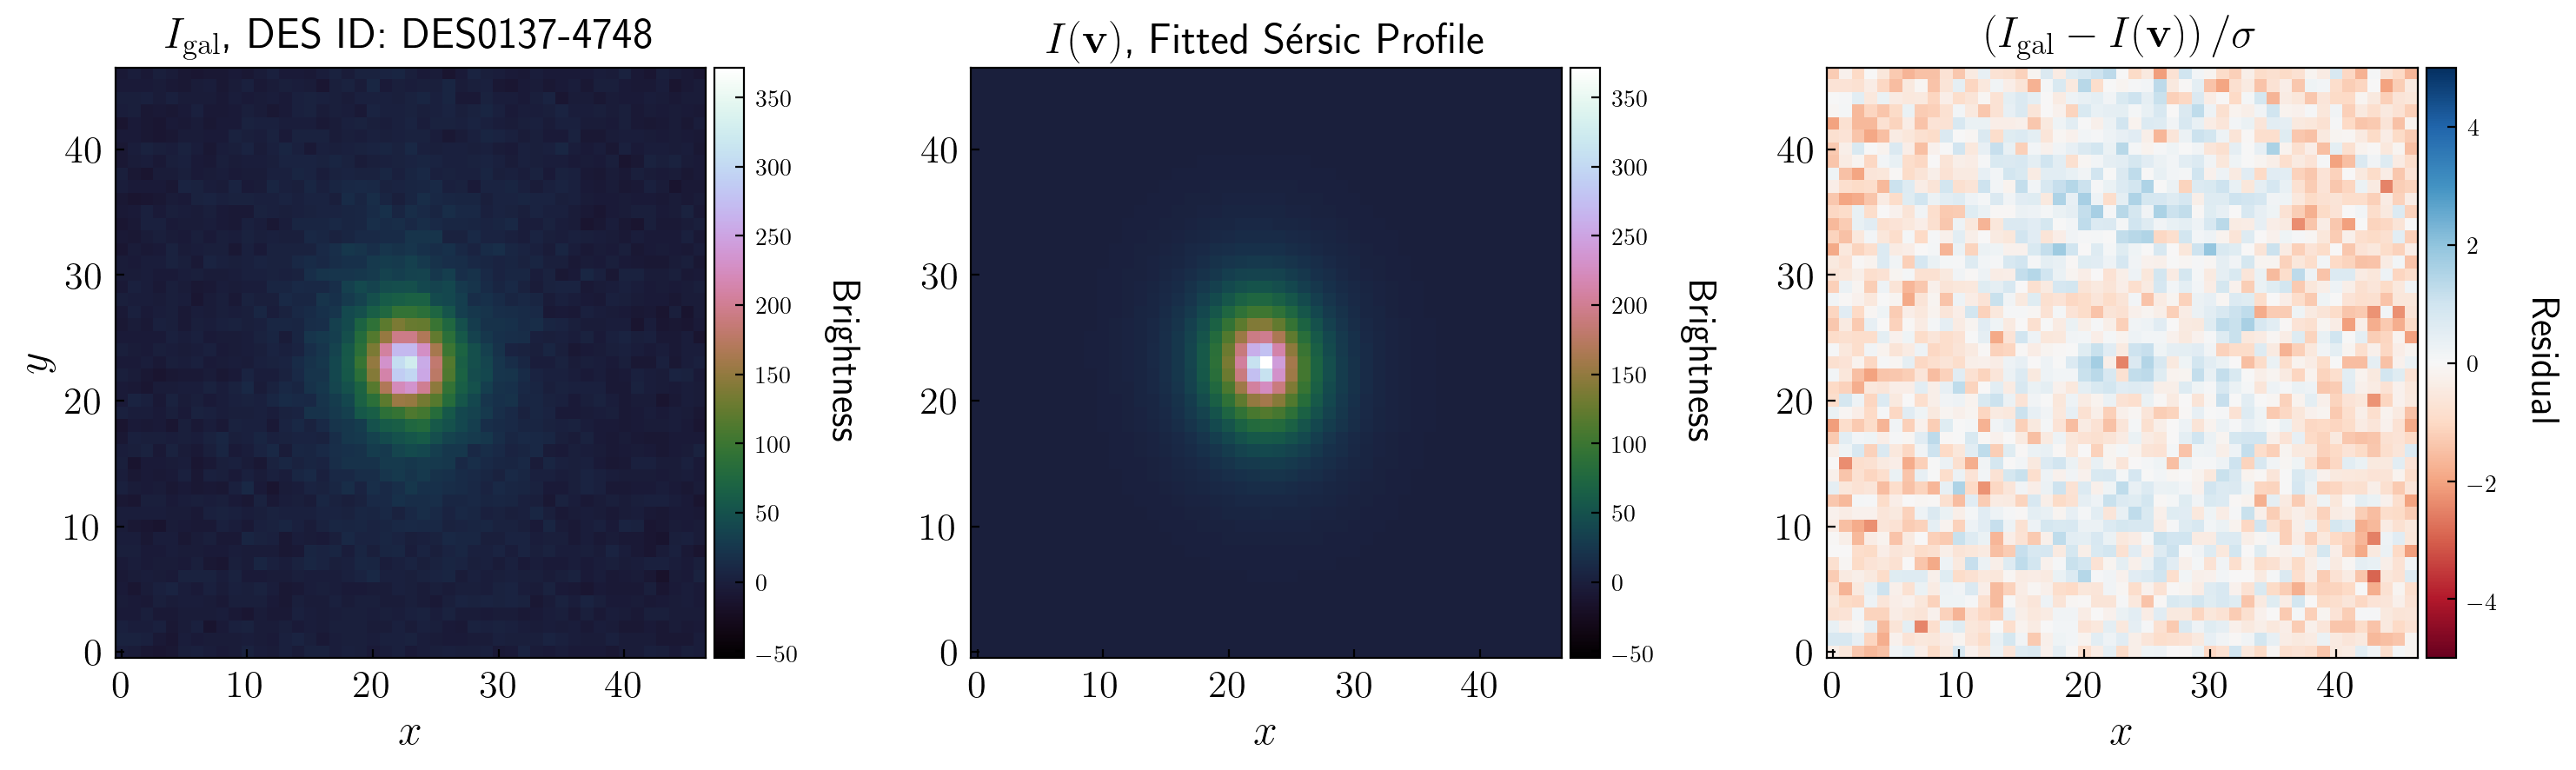

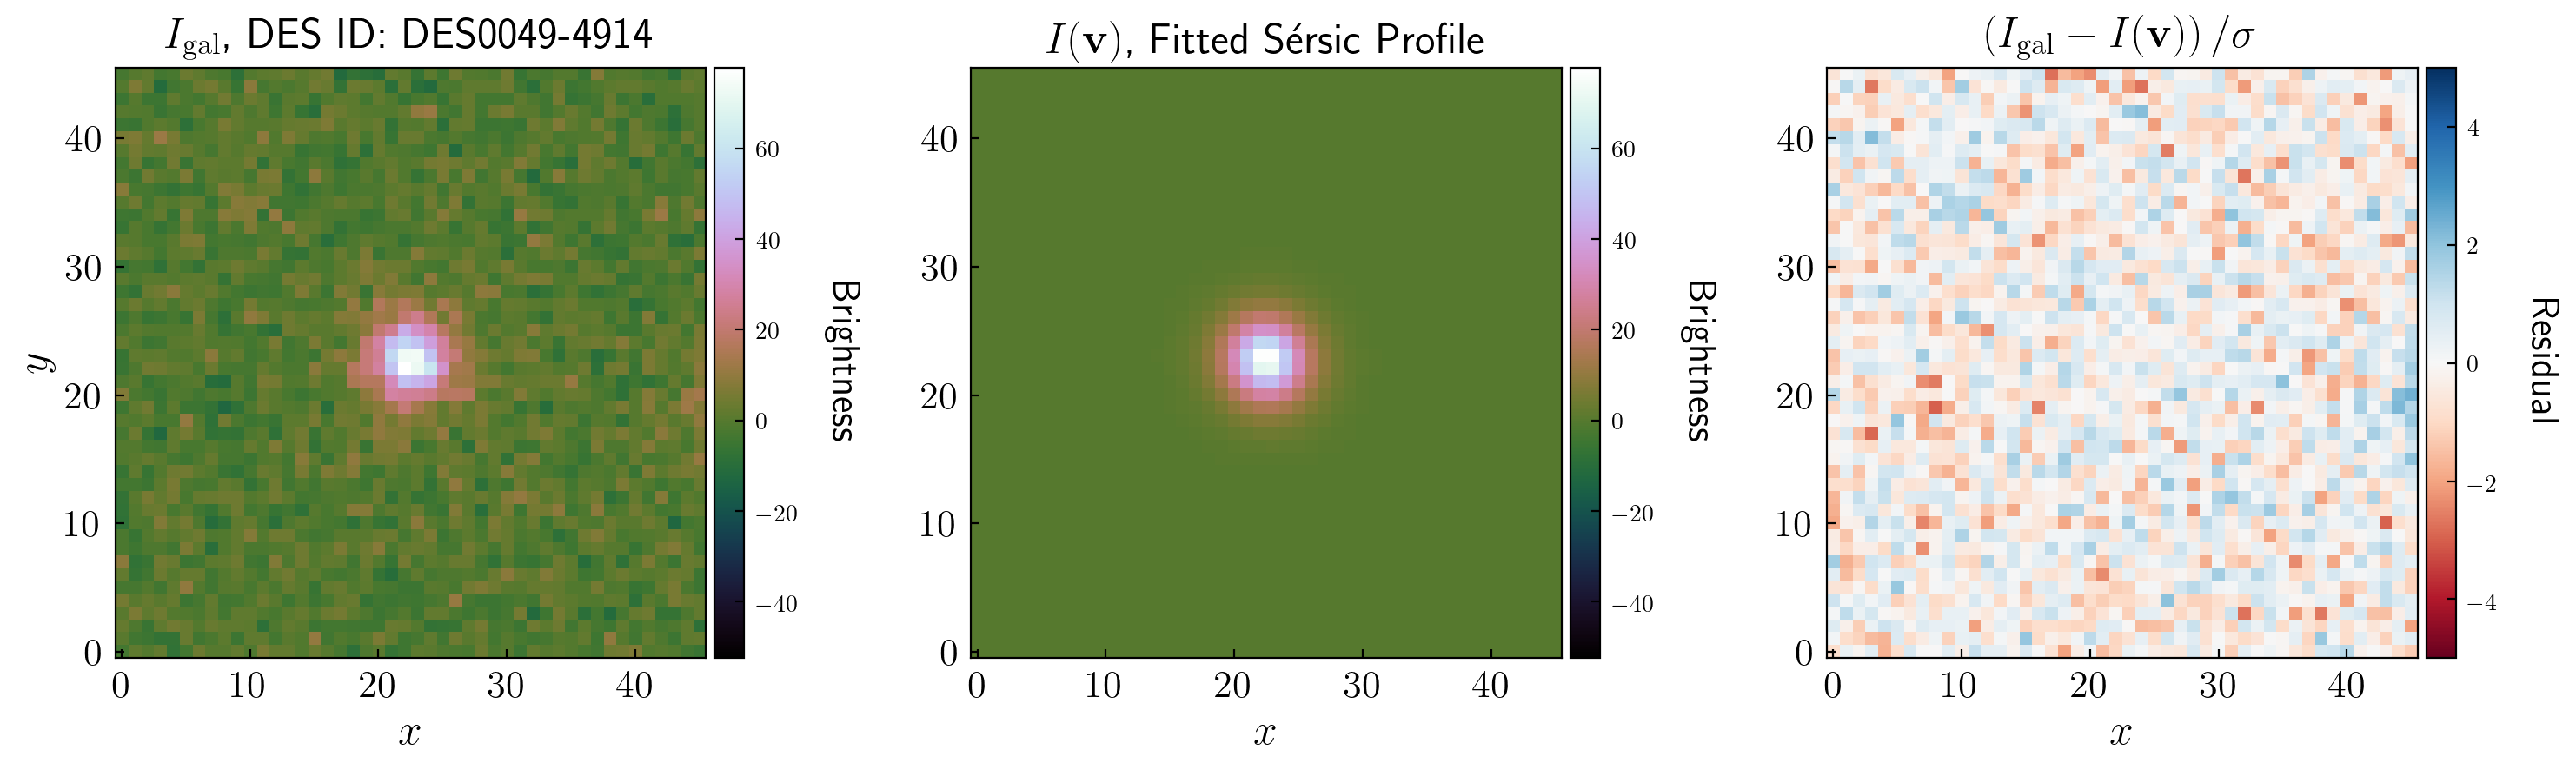

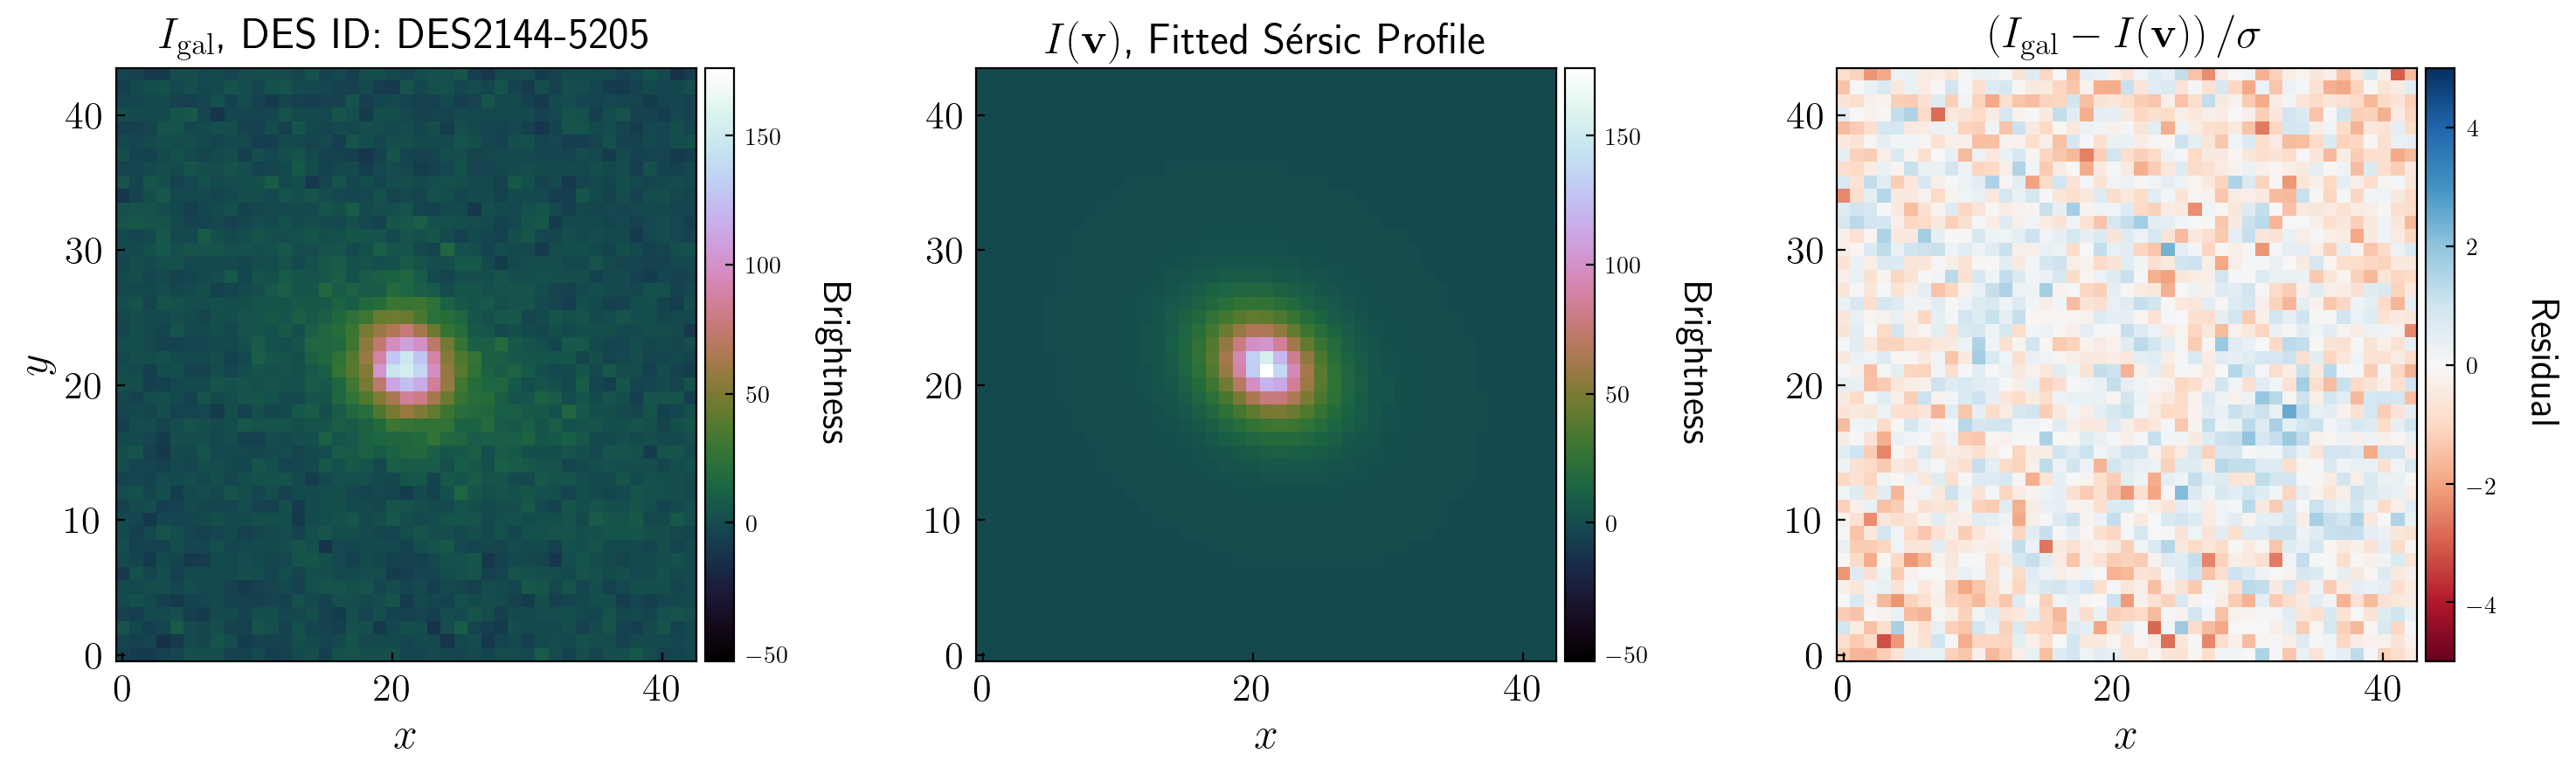

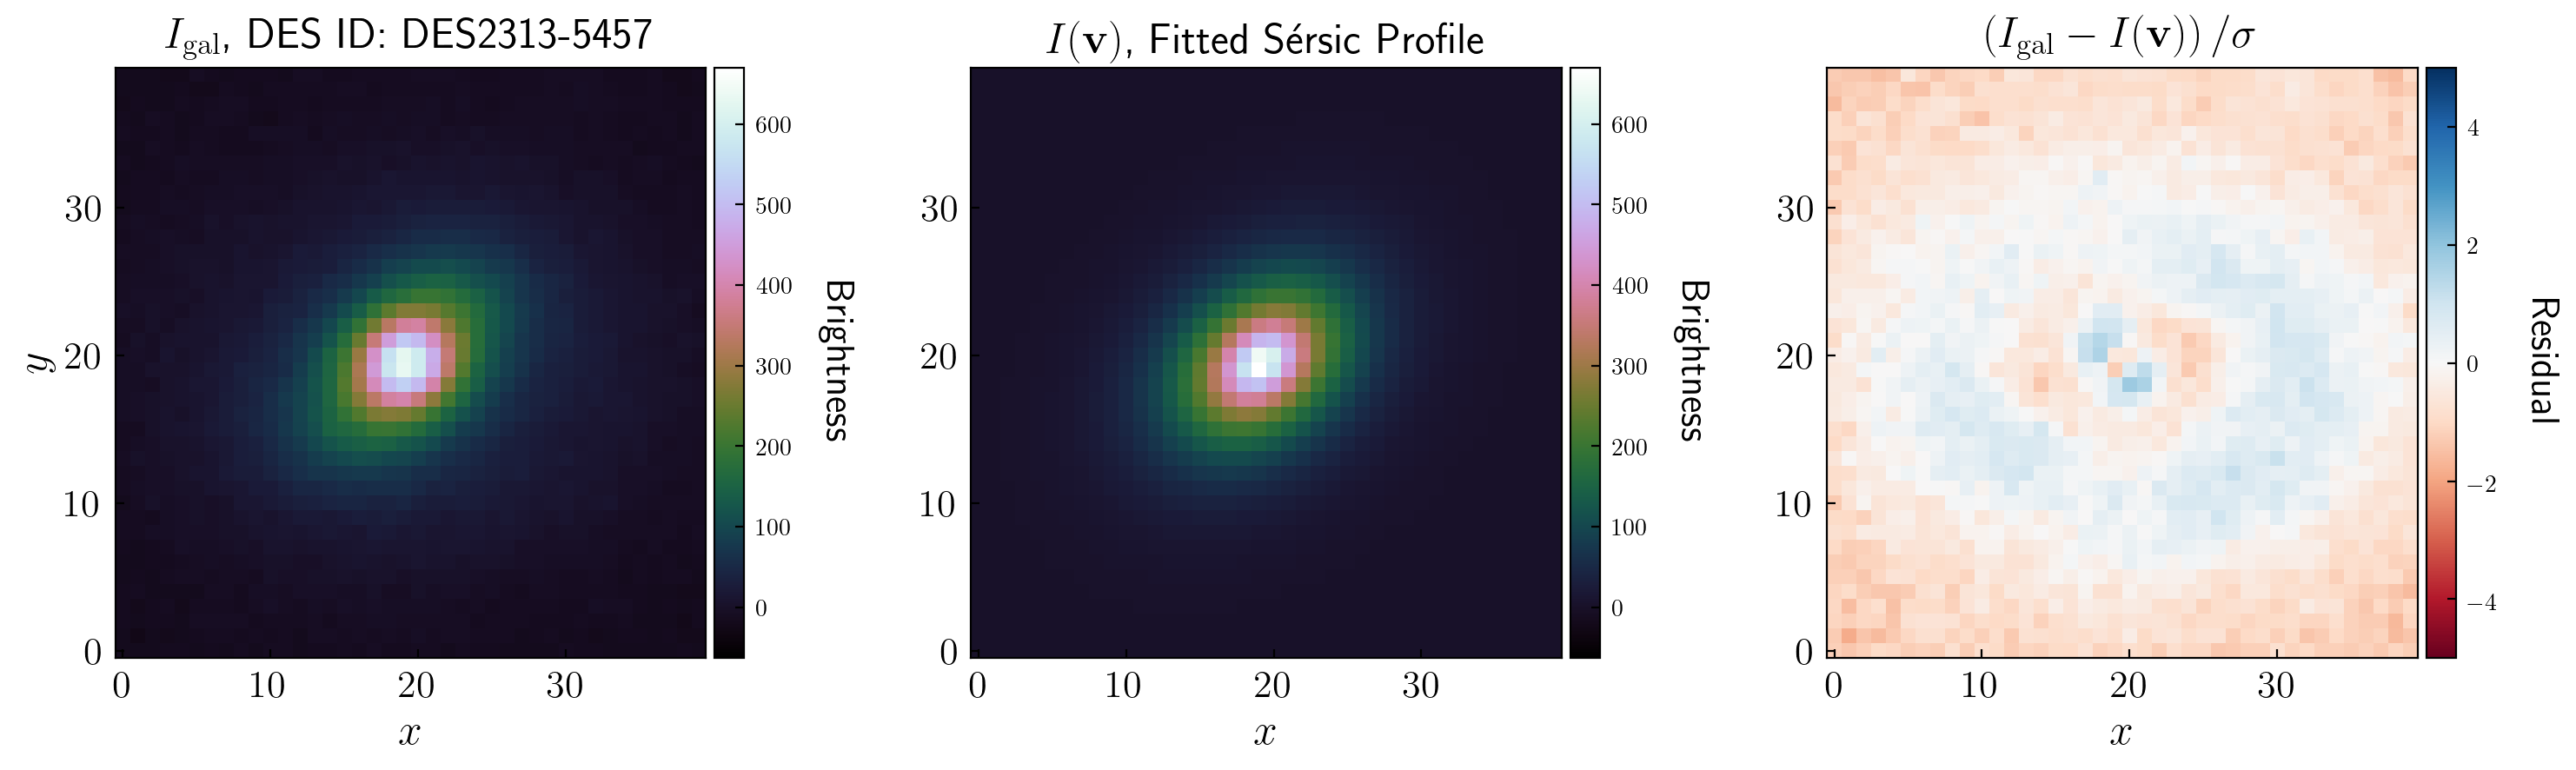

In [34]:
# plot all rescaled residual images

for i, row in enumerate(bestfit_table):
    
    values = list(row)
    
    desidi = values[0]
    
    params = values[1:8]
    params = np.array(params)
    
    funci = values[-1]  
    
    ai, ri, ni, x0i, y0i, ei, thi = params.copy()
    sersiciter = functional_models.Sersic2D(amplitude=ai, r_eff=ri, n=ni
                                            , x_0=x0i, y_0=y0i
                                            , ellip=ei, theta=thi)

    raw_image = read_fits_image(os.path.join(path, files[i]))
    
    nrow, ncol = raw_image.shape
    x, y = np.meshgrid(np.arange(ncol), np.arange(nrow))

    profile = sersiciter(x, y)
    
    
    print('{}\n---------------------------\n'.format(desidi))
    print("minimum at:\n")
    
    print('   amplitude = ', ai)
    print('   r_eff     = ', ri)
    print('   n         = ', ni)
    print('   x_0       = ', x0i)
    print('   y_0       = ', y0i)
    print('   ellip     = ', ei)
    print('   theta     = ', thi)
    
    print('\nE2 = {}\n'.format(funci))
    
    plot_raw_profile_rr(profile, raw_image, i)
    
    print('\n')

| $E_2/(n-n_{\rm params})$ | description |
| --- | --- |
| $\ll 1$ | model "overfits" the data (goes to close to the data values |
| $\approx 1$ | model is close to perfect |
| $>1$ | model may be close but is not capturing some aspect of the data |
| $\gg 1$ | model is not a correct description of the data |